# Mount, Installation, Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyreadr
!pip install basemap
!pip install geopandas
!pip install livelossplot
!pip install kerastuner-tensorboard-logger

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 363 kB 15.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 864 kB 15.2 MB/s 
     |████████████████████████████████| 30.5 MB 131.5 MB/s 
     |████████████████████████████████| 46 kB 2.7 MB/s 
     |████████████████████████████████| 6.3 MB 96.3 MB/s 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 14.3 MB/s 
     |████████████████████████████████| 16.7 MB 83.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 14.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 14.5 MB/s 


In [ ]:
import pyreadr
import pandas as pd
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import seaborn as sns
import shapely
from shapely.geometry import Point, LineString, Polygon, box
import geopandas as gpd
from descartes import PolygonPatch
from matplotlib.collections import PatchCollection
import random

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, Callback, ModelCheckpoint
from livelossplot import PlotLossesKeras

from kerastuner_tensorboard_logger import (TensorBoardLogger,setup_tb)
import keras_tuner
from kerastuner.tuners import Hyperband

from datetime import datetime
import pickle

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

# Data Exploration

## Reading in, Renaming

In [ ]:
# Einlesen von Datensatz aus RData
data_r = pyreadr.read_r('/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/data_full.RData')
data = data_r['data_DF']

In [ ]:
# Umbenennen der Wetterparameter
data = data.rename(columns = {'clim1': 'wind_u',
                       'clim2': 'wind_v',
                       'clim3': 'dew_temp',
                       'clim4': 'temp',
                       'clim5': 'pot_evap',
                       'clim6':'solar_rad',
                       'clim7': 'thermal_rad',
                       'clim8': 'pressure',
                       'clim9': 'evap',
                       'clim10': 'precip'})

## Variables, Size of Dataset, ...

In [ ]:
print('Parameter: \n' + str(data.keys().values))
n = len(data)
print('\nAnzahl Datenpunkte: {}'.format(n))
n_missing = data.isna().sum().sum()
print('Anzahl fehlende Datenpunkte: {}'.format(n_missing))

# Anzahl Wetterzellen
n_year = data.year.nunique()
n_month = data.month.nunique()
t = n_year * n_month
print('\nAnzahl Zeitschritte: {}'.format(t))
print('Anzahl Wetterzellen = #Datenpunkte/#Zeitschritte = {}'.format(int(n/t)))
# Alternativ:
# n_cells = len(data.loc[(data.year == 1993) & (data.month == 3)])
# print('Anzahl Datenpunkte März 1993: {}'.format(n_cells))

Parameter: 
['CNT' 'BA' 'lon' 'lat' 'area' 'year' 'month' 'lc1' 'lc2' 'lc3' 'lc4'
 'lc5' 'lc6' 'lc7' 'lc8' 'lc9' 'lc10' 'lc11' 'lc12' 'lc13' 'lc14' 'lc15'
 'lc16' 'lc17' 'lc18' 'altiMean' 'altiSD' 'wind_u' 'wind_v' 'dew_temp'
 'temp' 'pot_evap' 'solar_rad' 'thermal_rad' 'pressure' 'evap' 'precip']

Anzahl Datenpunkte: 563983
Anzahl fehlende Datenpunkte: 0

Anzahl Zeitschritte: 161
Anzahl Wetterzellen = #Datenpunkte/#Zeitschritte = 3503


In [ ]:
# no incongruences between CNT and BA
((data.CNT > 0) & (data.BA > 0) | (data.CNT == 0) & (data.BA == 0)).value_counts()

True    563983
dtype: int64

## Exploration of Grid

In [ ]:
#Plotting Grid

import shapely
from shapely.geometry import Point, LineString, Polygon, box
import geopandas as gpd
from descartes import PolygonPatch
from matplotlib.collections import PatchCollection

path = '/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/grid_plots/'

data_1993_3 = data.loc[(data.year == 1993) & (data.month == 3)]

fig, ax1 = plt.subplots(figsize=(18, 12))

map = Basemap(projection='aea',
            llcrnrlat = 23,
            llcrnrlon = -120,
            urcrnrlat = 47,
            urcrnrlon = -65,
            resolution='l',
            lon_0=-100,
            lat_0=40
            )

map.drawmapboundary(fill_color='lightskyblue')
map.drawcoastlines()
map.drawcountries(color='k', linewidth=2)
map.fillcontinents(color='cornsilk',lake_color='lightskyblue')
parallels = np.arange(20.,51,5.)
# labels = [left,right,top,bottom]
map.drawparallels(parallels,labels=[True,False,True,False], fontsize=16)
meridians = np.arange(230.,301.,10.)
map.drawmeridians(meridians, labels=[True,True,False,True], fontsize=16)

gridcells = []
for i in range(len(data_1993_3)):
  x = data_1993_3.iloc[i,2]
  y = data_1993_3.iloc[i,3]
  gridcells.append(box(x-0.25,y-0.25,x+0.25,y+0.25))

grid = gpd.GeoDataFrame(gridcells, columns=['geometry'])
grid['CNT'] = 0
grid['BA'] = 0
for i in range(len(data_1993_3)):
  grid.iloc[i,1] = data_1993_3.iloc[i,0]
  grid.iloc[i,2] = data_1993_3.iloc[i,1]

patches = []
for box in grid.geometry:
  mpoly = shapely.ops.transform(map, box)
  patches.append(PolygonPatch(mpoly))

ax1.add_collection(PatchCollection(patches, match_original=True, zorder=2, facecolor=(0,0,0,0), linewidth=0.75))

plt.savefig(path + 'Grid.png')

plt.show()

In [ ]:
def plot_grid_data(data, year, month, var, norm_quantile=0.99, save=True):
  '''
  Function to plot scale of variables in each grid cell.

  Choosing parameters:
  year: int between 1993 and 2015
  month: int between 3 and 9
  var: ['CNT', 'BA', 'altiMean', 'altiSD', 'wind', 'dew_temp', 'temp', 'pot_evap', 'solar_rad', 'thermal_rad', 'pressure', 'evap', 'precip']
  '''

  path = '/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/grid_plots/' + var + '/'

  fig, ax1 = plt.subplots(figsize=(18, 12))

  map = Basemap(projection='aea',
              llcrnrlat = 23,
              llcrnrlon = -120,
              urcrnrlat = 47,
              urcrnrlon = -65,
              resolution='l',
              lon_0=-100,
              lat_0=40
              )

  map.drawmapboundary(fill_color='lightskyblue')
  map.drawcoastlines()
  map.drawcountries(color='k', linewidth=2)
  map.fillcontinents(color='cornsilk',lake_color='lightskyblue')
  parallels = np.arange(20.,51,5.)
  # labels = [left,right,top,bottom]
  map.drawparallels(parallels,labels=[True,False,True,False], fontsize=16)
  meridians = np.arange(230.,301.,10.)
  map.drawmeridians(meridians, labels=[True,True,False,True], fontsize=16)

  # zuerst Wind unterscheiden oder Vektorfeld
  data_month = data.loc[(data.year == year) & (data.month == month)].reset_index(drop=True)
  if var in ['temp', 'dew_temp', 'pressure']:
    norm_factor = (data[var]-data[var].min()).quantile(norm_quantile)
  else:
    norm_factor = data[var].quantile(norm_quantile)

  gridcells = []
  for i in range(len(data_month)):
    x = data_month.iloc[i,2]
    y = data_month.iloc[i,3]
    gridcells.append(box(x-0.25,y-0.25,x+0.25,y+0.25))

  grid = gpd.GeoDataFrame(gridcells, columns=['geometry'])
  grid[var] = 0
  for i in range(len(data_month)):
    grid.iloc[i,1] = data_month.loc[i,var]-data[var].min()

  patches = []
  for i in range(len(grid)):
    if grid.iloc[i,1] < 0:
      alpha = 0
    elif grid.iloc[i,1] > norm_factor:
      alpha = 1
    else:
      alpha = grid.iloc[i,1] / norm_factor
    mpoly = shapely.ops.transform(map, grid.iloc[i,0])
    if var in ['CNT','BA','dew_temp', 'temp', 'thermal_rad']:
      patches.append(PolygonPatch(mpoly, fc=(1,0,0,alpha))) #red
    elif var in ['altiMean', 'altiSD', 'pressure']:
      patches.append(PolygonPatch(mpoly, fc=(205/255,133/255,63/255,alpha))) #brown
    elif var in ['solar_rad']:
      patches.append(PolygonPatch(mpoly, fc=(1,1,102/255,alpha))) #yellow
    elif var in ['pot_evap', 'evap', 'precip']:
      patches.append(PolygonPatch(mpoly, fc=(0,0,1,alpha))) #blue


  ax1.add_collection(PatchCollection(patches, match_original=True, zorder=2, linewidth=0.75))

  variable_dict = {'CNT'          : 'Number of Wildfires',
                    'BA'          : 'Burnt Area',
                    'altiMean'    : 'Mean Altitude',
                    'altiSD'      : 'Standard Deviation of Altitude',
                    'dew_temp'    : 'Dewpoint Temperature',
                    'temp'        : 'Temperature',
                    'pot_evap'    : 'Potential Evaporation',
                    'solar_rad'   : 'Solar Radiation',
                    'thermal_rad' : 'Thermal Radiation',
                    'pressure'    : 'Pressure',
                    'evap'        : 'Evaporation',
                    'precip'      : 'Precipitation'}
  variable = variable_dict[var]

  month_dict = {3: 'March',
                4: 'April',
                5: 'May',
                6: 'June',
                7: 'July',
                8: 'August',
                9: 'September'}
  month_name = month_dict[month]

  ax1.set_title(variable + ' ' + month_name + ' ' + str(year), fontsize=24, y=1.037)

  if save == True:
    plt.savefig(path + 'Grid_' + var + '_' + str(year) + '_' + str(month) + '_' + 'quantile_' + str(norm_quantile) + '.png')

  plt.show()

In [ ]:
#plot and save all grids with different variables
# for year in range(1993,2016):
#   for month in range(3,10):
#     plot_grid_data(data, year, month, 'precip', norm_quantile=0.99, save=True)

## Histograms

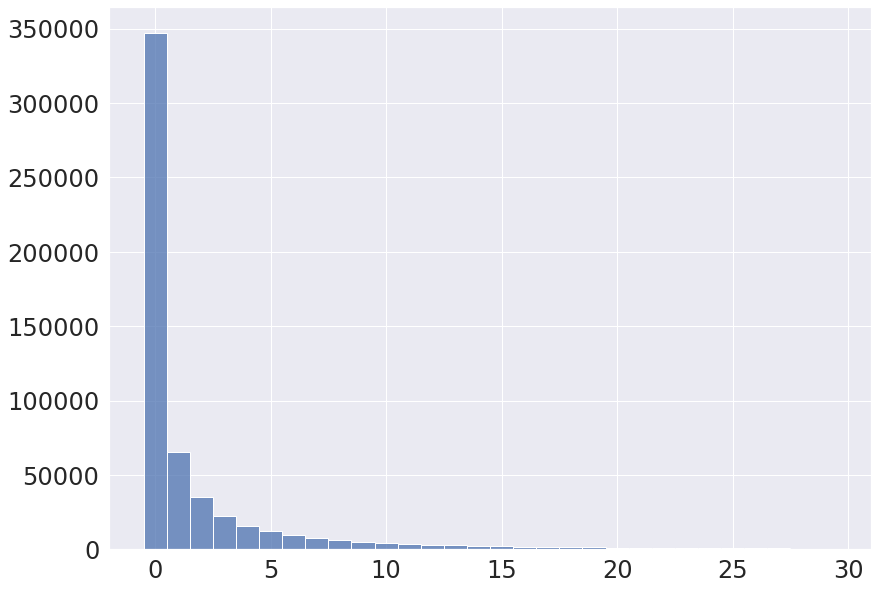

In [ ]:
var = data[data.CNT<data.CNT.quantile(0.99)]

sns.set()
fig, ax1 = plt.subplots(figsize=(12,8))

sns.histplot(data=var, x="CNT", discrete=True, ax=ax1)

# ax1.set_xlabel('Number of Wildfires', fontsize=20)

plt.tick_params(axis='both', which='major', labelsize=24)

ax1.set(ylabel='')
ax1.set(xlabel='')
plt.tight_layout(pad=0)

plt.show()

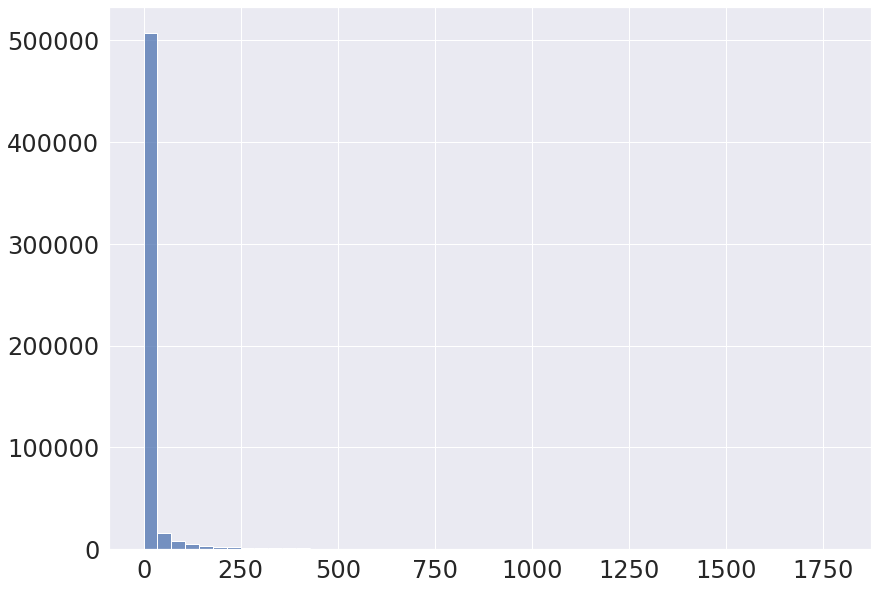

In [ ]:
var = data[data.BA<data.BA.quantile(0.99)]

sns.set()
fig, ax1 = plt.subplots(figsize=(12,8))

sns.histplot(data=var, x="BA", ax=ax1, bins=50)

# ax1.set_xlabel('Number of Wildfires', fontsize=20)

plt.tick_params(axis='both', which='major', labelsize=24)

ax1.set(ylabel='')
ax1.set(xlabel='')
plt.tight_layout(pad=0)

plt.show()

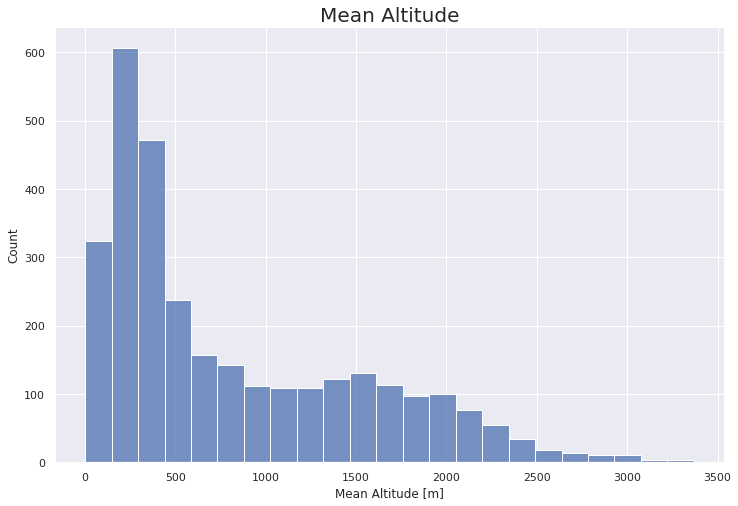

In [ ]:
sns.set()
fig, ax1 = plt.subplots(figsize=(12,8))

sns.histplot(data=data[:3052], x="altiMean", ax=ax1)

# ax2 = ax1.twinx()
# sns.kdeplot(data=data, x="altiMean", ax=ax2, color='orange', clip=(0,data[:3052].altiMean.max()))

ax1.set_xlabel('Mean Altitude [m]')
ax1.set_title('Mean Altitude', fontsize=20)
# ax2.set_yticks([])
# ax2.set_ylabel('')

plt.show()

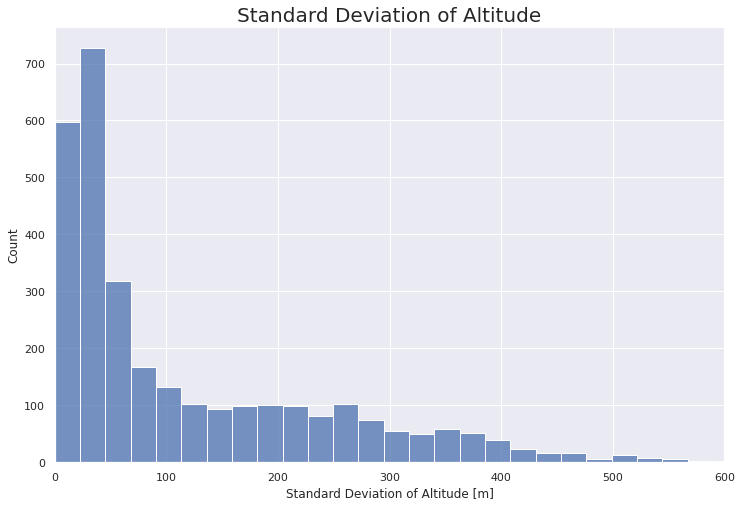

In [ ]:
set()
fig, ax1 = plt.subplots(figsize=(12,8))

sns.histplot(data=data[:3052], x="altiSD", ax=ax1)

# ax2 = ax1.twinx()
# sns.kdeplot(data=data, x="altiMean", ax=ax2, color='orange', clip=(0,data[:3052].altiSD.max()))

ax1.set_xlabel('Standard Deviation of Altitude [m]')
ax1.set_title('Standard Deviation of Altitude', fontsize=20)
ax1.set_xlim(0,600)
# ax2.set_yticks([])
# ax2.set_ylabel('')

plt.show()

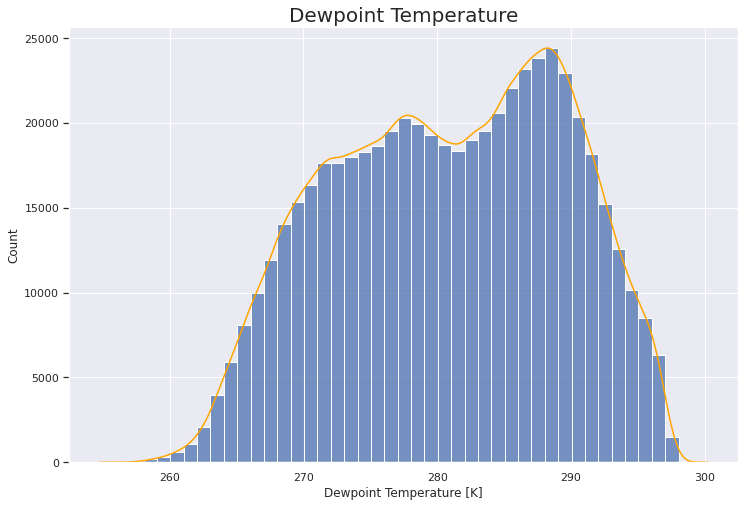

In [ ]:
sns.set()
fig, ax1 = plt.subplots(figsize=(12,8))

sns.histplot(data=data, x="dew_temp", discrete=True, ax=ax1)

ax2 = ax1.twinx()
sns.kdeplot(data=data, x="dew_temp", ax=ax2, color='orange')

ax1.set_xlabel('Dewpoint Temperature [K]')
ax1.set_title('Dewpoint Temperature', fontsize=20)
ax2.set_yticks([])
ax2.set_ylabel('')

plt.show()

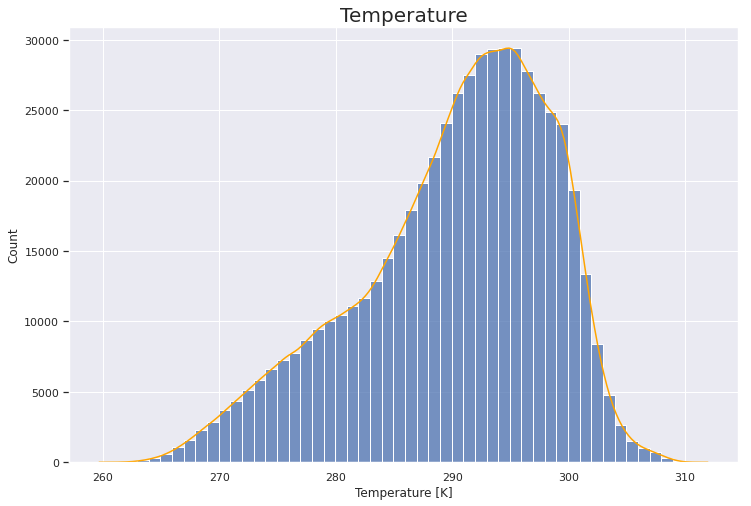

In [ ]:
sns.set()
fig, ax1 = plt.subplots(figsize=(12,8))

sns.histplot(data=data, x="temp", discrete=True, ax=ax1)

ax2 = ax1.twinx()
sns.kdeplot(data=data, x="temp", ax=ax2, color='orange')

ax1.set_xlabel('Temperature [K]')
ax1.set_title('Temperature', fontsize=20)
ax2.set_yticks([])
ax2.set_ylabel('')

plt.show()

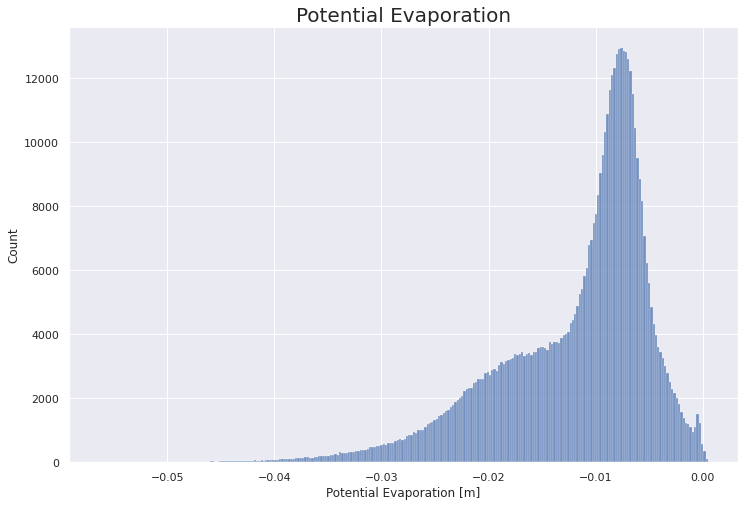

In [ ]:
sns.set()
fig, ax1 = plt.subplots(figsize=(12,8))

sns.histplot(data=data, x='pot_evap', ax=ax1)

# ax2 = ax1.twinx()
# sns.kdeplot(data=data, x="pot_evap", ax=ax2, color='orange')

ax1.set_xlabel('Potential Evaporation [m]')
ax1.set_title('Potential Evaporation', fontsize=20)
# ax2.set_yticks([])
# ax2.set_ylabel('')

plt.show()

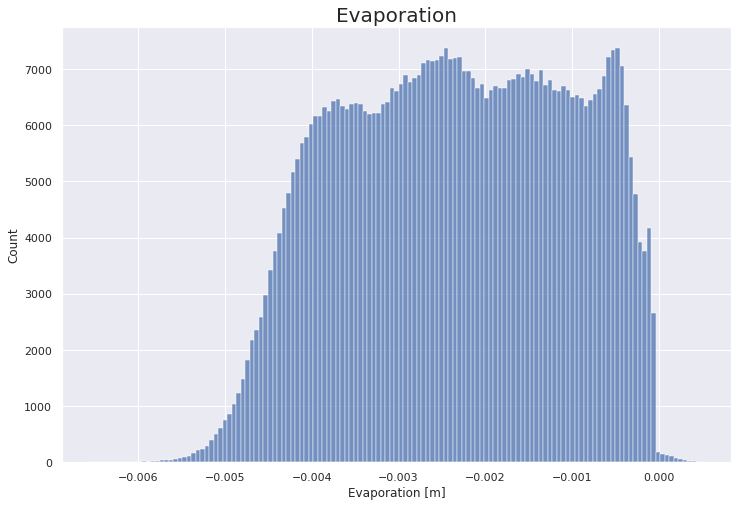

In [ ]:
sns.set()
fig, ax1 = plt.subplots(figsize=(12,8))

sns.histplot(data=data, x='evap', ax=ax1)

# ax2 = ax1.twinx()
# sns.kdeplot(data=data, x="evap", ax=ax2, color='orange')

ax1.set_xlabel('Evaporation [m]')
ax1.set_title('Evaporation', fontsize=20)
# ax2.set_yticks([])
# ax2.set_ylabel('')

plt.show()

In [ ]:
# Positive Numbers for evaporation represent condensation

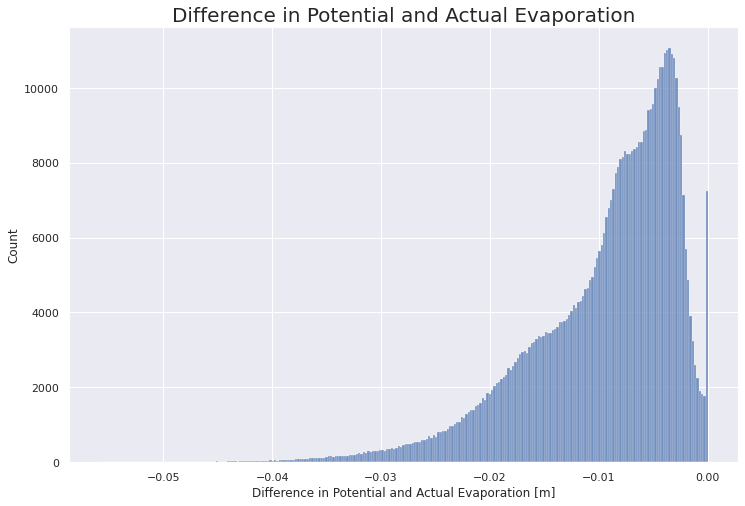

In [ ]:
var=data.pot_evap-data.evap

sns.set()
fig, ax1 = plt.subplots(figsize=(12,8))

sns.histplot(data=var, ax=ax1)

# ax2 = ax1.twinx()
# sns.kdeplot(data=data, x="pot_evap", ax=ax2, color='orange')

ax1.set_xlabel('Difference in Potential and Actual Evaporation [m]')
ax1.set_title('Difference in Potential and Actual Evaporation', fontsize=20)
# ax2.set_yticks([])
# ax2.set_ylabel('')

plt.show()

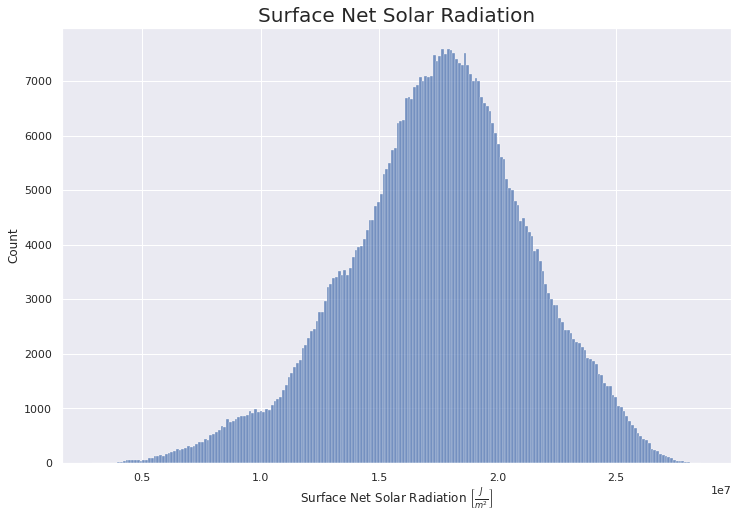

In [ ]:
sns.set()
fig, ax1 = plt.subplots(figsize=(12,8))

sns.histplot(data=data, x='solar_rad', ax=ax1)

# ax2 = ax1.twinx()
# sns.kdeplot(data=data, x="evap", ax=ax2, color='orange')

ax1.set_xlabel(r'Surface Net Solar Radiation $\left[\frac{J}{m^2}\right]$')
ax1.set_title('Surface Net Solar Radiation', fontsize=20)
# ax2.set_yticks([])
# ax2.set_ylabel('')

plt.show()

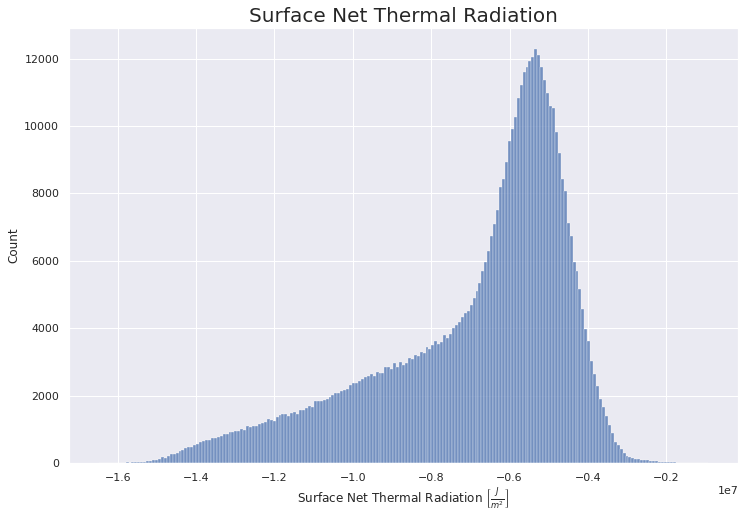

In [ ]:
sns.set()
fig, ax1 = plt.subplots(figsize=(12,8))

sns.histplot(data=data, x='thermal_rad', ax=ax1)

# ax2 = ax1.twinx()
# sns.kdeplot(data=data, x="evap", ax=ax2, color='orange')

ax1.set_xlabel(r'Surface Net Thermal Radiation $\left[\frac{J}{m^2}\right]$')
ax1.set_title('Surface Net Thermal Radiation', fontsize=20)
# ax2.set_yticks([])
# ax2.set_ylabel('')

plt.show()

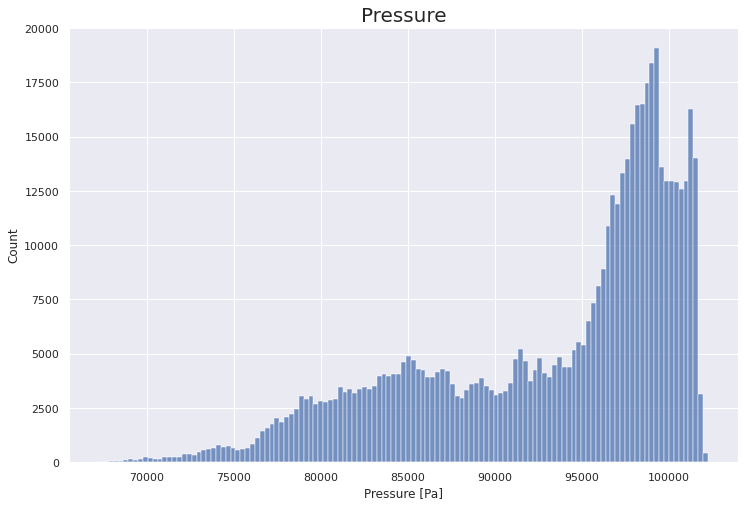

In [ ]:
sns.set()
fig, ax1 = plt.subplots(figsize=(12,8))

sns.histplot(data=data, x='pressure', ax=ax1)

# ax2 = ax1.twinx()
# sns.kdeplot(data=data, x="evap", ax=ax2, color='orange')

ax1.set_xlabel('Pressure [Pa]')
ax1.set_title('Pressure', fontsize=20)
# ax2.set_yticks([])
# ax2.set_ylabel('')

plt.show()

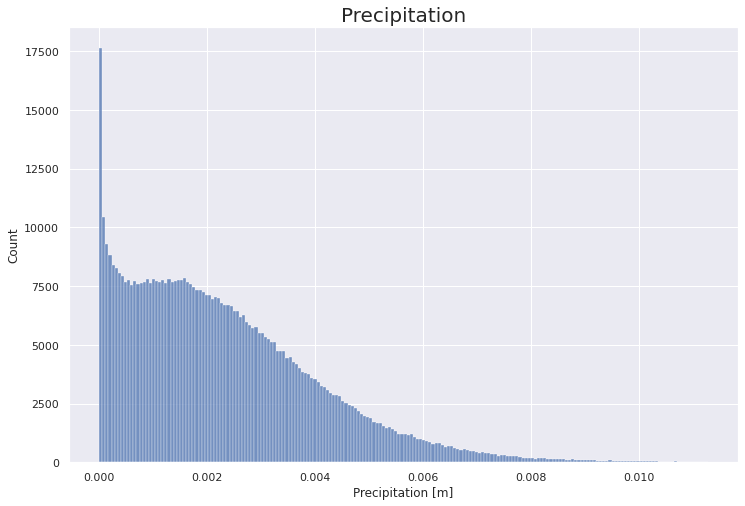

In [ ]:
var = data[data.precip<data.precip.quantile(0.999)]

sns.set()
fig, ax1 = plt.subplots(figsize=(12,8))

sns.histplot(data=var, x='precip', ax=ax1)

# ax2 = ax1.twinx()
# sns.kdeplot(data=data, x="evap", ax=ax2, color='orange')

ax1.set_xlabel('Precipitation [m]')
ax1.set_title('Precipitation', fontsize=20)
# ax2.set_yticks([])
# ax2.set_ylabel('')

plt.show()

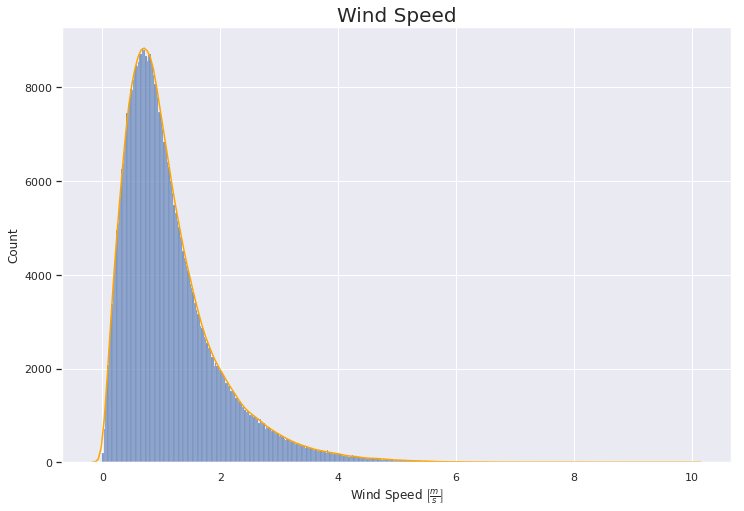

In [ ]:
wspd = np.sqrt(data.wind_u**2+data.wind_v**2)

fig, ax1 = plt.subplots(figsize=(12,8))

sns.histplot(data=wspd, ax=ax1)

ax2 = ax1.twinx()
sns.kdeplot(data=wspd, ax=ax2, color='orange')

ax1.set_xlabel(r'Wind Speed $\left[\frac{m}{s}\right]$')
ax1.set_title('Wind Speed', fontsize=20)
ax2.set_yticks([])
ax2.set_ylabel('')

plt.show()

In [ ]:
# classic weibull distribution of windspeed

## Correalation

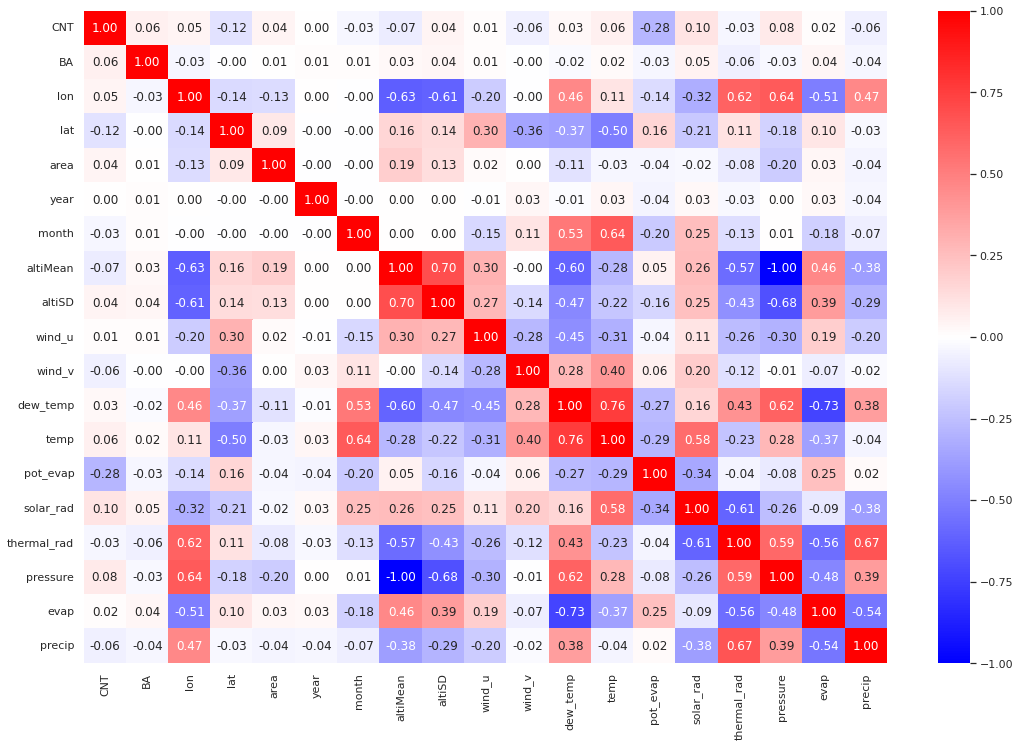

In [ ]:
#show correlation of weather variables with target variables.
path = '/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/Plots/'
lc_params = ['lc1', 'lc2', 'lc3', 'lc4', 'lc5', 'lc6', 'lc7', 'lc8', 'lc9',
             'lc10', 'lc11', 'lc12', 'lc13', 'lc14', 'lc15', 'lc16', 'lc17', 'lc18']
fig, ax = plt.subplots(figsize=(18,12))
sns.heatmap(data.drop(lc_params, axis=1).corr(), vmin=-1, vmax=1, cmap='bwr', annot=True, fmt='.2f')
plt.savefig(path + 'corr_meterological.png')
plt.show()

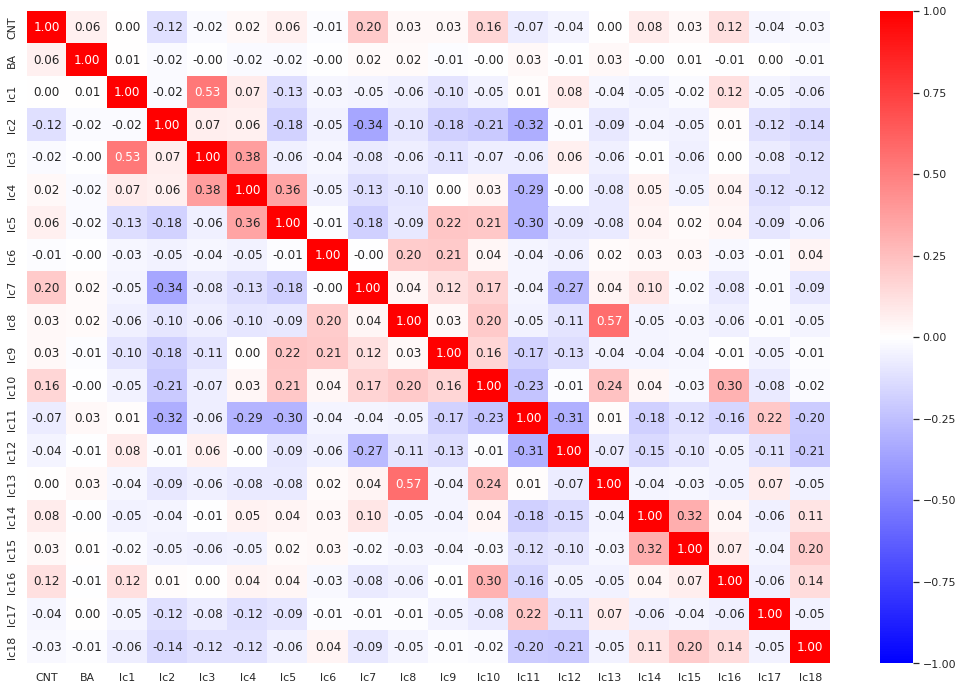

In [ ]:
fig, ax = plt.subplots(figsize=(18,12))
sns.heatmap(data[['CNT', 'BA']+lc_params].corr(), vmin=-1, vmax=1, cmap='bwr', annot=True, fmt='.2f')
plt.savefig(path + 'corr_landuse.png')
plt.show()

## Datapoints with high wildfire prevalence

In [ ]:
no_fire  = data[data.CNT == 0]
fire = data[data.CNT > 0]

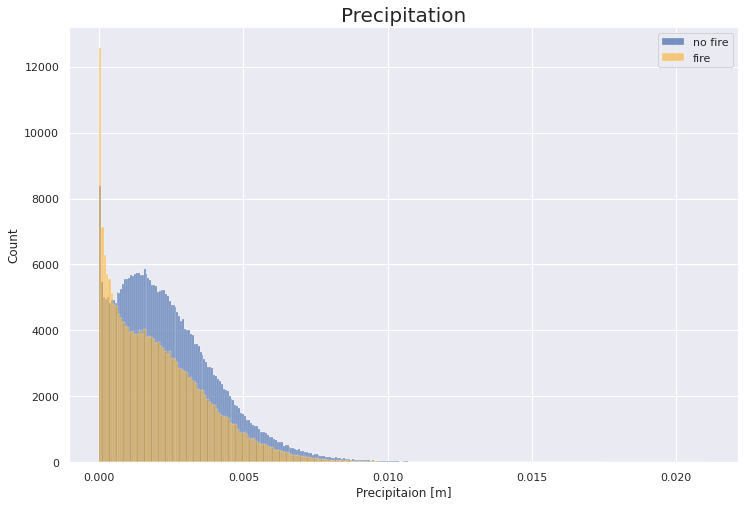

In [ ]:
sns.set()
fig, ax1 = plt.subplots(figsize=(12,8))

sns.histplot(data=no_fire, x="precip", ax=ax1, label='no fire')
sns.histplot(data=fire, x="precip", ax=ax1, color='orange', alpha=0.5, label='fire')

# ax2 = ax1.twinx()
# sns.kdeplot(data=data, x="temp", ax=ax2, color='orange')

ax1.set_xlabel('Precipitaion [m]')
ax1.set_title('Precipitation', fontsize=20)
# ax2.set_yticks([])
# ax2.set_ylabel('')
plt.legend()
plt.show()

# Define Functions

## Transformation

In [ ]:
# one-hot-encoding of month
# data = pd.concat([data, pd.get_dummies(data['month'], prefix='month')],axis=1).drop(['month'], axis=1)

In [ ]:
def transform_month(df, drop=True):
  df['month_sin'] = np.sin(2*np.pi*(df.month)/12)
  df['month_cos'] = np.cos(2*np.pi*(df.month)/12)
  if drop == True:
    df = df.drop(['month'], axis=1)
  return df

## Split training and testing data

In [ ]:
def split_train_test(data, val=True):
  random.seed(1)
  years = list(range(1993,2016))
  year_val = []
  year_test = []

  for i in range(4):
    rand_year = years[random.randint(0,len(years)-i)]
    years.remove(rand_year)
    year_val.append(rand_year)
  year_val.sort()

  data_val = data[data.year.isin(year_val)]

  for i in range(4):
    rand_year = years[random.randint(0,len(years)-i)]
    years.remove(rand_year)
    year_test.append(rand_year)
  year_test.sort()

  year_train = list(range(1993,2016))
  year_train = [i for i in year_train if i not in year_val + year_test]
  if val == False:
    year_train.extend(year_val)
  year_train.sort()

  data_train = data[data.year.isin(year_train)]
  data_test = data[data.year.isin(year_test)]

  print('Training years: ' + str(year_train))
  print('Test years: ' + str(year_test))

  if val == True:
    print('Validation years: ' + str(year_val))
    return data_train, data_val, data_test
  else:
    return data_train, data_test

## Normalize Input Data

In [ ]:
# Normalize Data. 'area', land cover does not need to be normalized

In [ ]:
def preproc(df_in, means=None, stds=None, wspd=False, dryness=False):

  norm_list = ['lon', 'lat','year', 'altiMean', 'altiSD',
       'wind_u', 'wind_v', 'dew_temp', 'temp', 'pot_evap', 'solar_rad',
       'thermal_rad', 'pressure', 'evap', 'precip']

  if wspd == True:
    norm_list.append('wspd')
  if dryness == True:
    norm_list.append('dryness')

  X = df_in.drop(['CNT', 'BA'], axis=1)
  y_CNT = df_in.CNT
  y_BA = df_in.BA

  if means is None:
    means = X[norm_list].mean()
  if stds  is None:
    stds  = X[norm_list].std()

  X[norm_list] = (X[norm_list] - means) / stds

  return X, y_CNT, y_BA, means, stds

## Feature Engineering

In [ ]:
def windspeed(df):
  df['wspd'] = np.sqrt(df.wind_u**2+df.wind_v**2)
  return df

## Print MSE

In [ ]:
def print_mse(m, X_train, X_val, X_test, y_train, y_val, y_test):
  pred_train = m.predict(X_train, batch_size=1024)
  pred_val = m.predict(X_val, batch_size=1024)
  pred_test = m.predict(X_test, batch_size=1024)

  mse_train = mean_squared_error(pred_train, y_train)
  mse_val = mean_squared_error(pred_val, y_val)
  mse_test = mean_squared_error(pred_test, y_test)

  print('Train MSE = {}'.format(np.round(mse_train,4)))
  print('Validation MSE = {}'.format(np.round(mse_val,4)))
  print('Test MSE = {}'.format(np.round(mse_test,4)))

In [ ]:
def print_mse_rfr(m, X_train, X_test, y_train, y_test):
  pred_train = m.predict(X_train)
  pred_test = m.predict(X_test)

  mse_train = mean_squared_error(pred_train, y_train)
  mse_test = mean_squared_error(pred_test, y_test)

  print('Train MSE = {}'.format(np.round(mse_train,4)))
  print('Test MSE = {}'.format(np.round(mse_test,4)))

# Naive Benchmark

In [ ]:
data_train, data_test = split_train_test(data, val=False)

X_train, y_train_CNT, y_train_BA, means, stds = preproc(data_train)
X_test, y_test_CNT, y_test_BA, _, _ = preproc(data_test, means, stds)

Training years: [1993, 1994, 1996, 1999, 2000, 2001, 2002, 2005, 2006, 2007, 2008, 2009, 2010, 2014, 2015]
Test years: [1998, 2004, 2011, 2013]


In [ ]:
mean_CNT = np.full(shape=len(X_train), fill_value=y_train_CNT.mean())
mean_BA = np.full(shape=len(X_test), fill_value=y_train_BA.mean())

In [ ]:
mse_train_CNT = np.round(mean_squared_error(np.full(shape=len(X_train), fill_value=y_train_CNT.mean()),y_train_CNT),4)
mse_test_CNT = np.round(mean_squared_error(np.full(shape=len(X_test), fill_value=y_train_CNT.mean()),y_test_CNT),4)
mse_train_BA = np.round(mean_squared_error(np.full(shape=len(X_train), fill_value=y_train_BA.mean()),y_train_BA),4)
mse_test_BA = np.round(mean_squared_error(np.full(shape=len(X_test), fill_value=y_train_BA.mean()),y_test_BA),4)
print('Training MSE CNT: {}'.format(mse_train_CNT))
print('Training MSE BA: {}'.format(mse_train_BA))
print('Test MSE CNT: {}'.format(mse_test_CNT))
print('Test MSE BA: {}'.format(mse_test_BA))

Training MSE CNT: 43.592
Training MSE BA: 12917566.2971
Test MSE CNT: 38.6506
Test MSE BA: 11488426.8236


# Linear Regression

In [ ]:
def lin_reg(X_train, y_train_CNT, y_train_BA, X_test, y_test_CNT, y_test_BA):
  # sklearn model
  lr_CNT = LinearRegression()
  lr_BA = LinearRegression()

  # sklearn model training
  lr_CNT.fit(X_train, y_train_CNT)
  lr_BA.fit(X_train, y_train_BA)

  # statsmodel for summary function
  X_train_sm = sm.add_constant(X_train)
  lr_train_CNT_sm = sm.OLS(y_train_CNT, X_train_sm)
  fit_train_CNT_sm = lr_train_CNT_sm.fit()
  lr_train_BA_sm = sm.OLS(y_train_BA, X_train_sm)
  fit_train_BA_sm = lr_train_BA_sm.fit()

  # predictions
  pred_CNT_train = lr_CNT.predict(X_train)
  pred_BA_train = lr_BA.predict(X_train)
  pred_CNT_test = lr_CNT.predict(X_test)
  pred_BA_test = lr_BA.predict(X_test)

  # R²
  R_sq_train_CNT = np.round(lr_CNT.score(X_train, y_train_CNT),4)
  R_sq_train_BA = np.round(lr_BA.score(X_train, y_train_BA),4)
  R_sq_test_CNT = np.round(lr_CNT.score(X_test, y_test_CNT),4)
  R_sq_test_BA = np.round(lr_BA.score(X_test, y_test_BA),4)
  print('\nTraining R² CNT: {}'.format(R_sq_train_CNT))
  print('Training R² BA: {}'.format(R_sq_train_BA))
  print('Test R² CNT: {}'.format(R_sq_test_CNT))
  print('Test R² BA: {}'.format(R_sq_test_BA))
  print()

  # MSE
  mse_train_CNT = np.round(mean_squared_error(pred_CNT_train, y_train_CNT),4)
  mse_train_BA = np.round(mean_squared_error(pred_BA_train, y_train_BA),4)
  mse_test_CNT = np.round(mean_squared_error(pred_CNT_test, y_test_CNT),4)
  mse_test_BA = np.round(mean_squared_error(pred_CNT_test, y_test_BA),4)
  print('Training MSE CNT: {}'.format(mse_train_CNT))
  print('Training MSE BA: {}'.format(mse_train_BA))
  print('Test MSE CNT: {}'.format(mse_test_CNT))
  print('Test MSE BA: {}'.format(mse_test_BA))
  print()

  # summary
  print('Linear Regression CNT:')
  print(fit_train_CNT_sm.summary())
  print()
  print('Linear Regression BA:')
  print(fit_train_BA_sm.summary())

## without windspeed

In [ ]:
df = transform_month(data)

In [ ]:
data_train, data_test = split_train_test(df, val=False)

X_train, y_train_CNT, y_train_BA, means, stds = preproc(data_train)
X_test, y_test_CNT, y_test_BA, _, _ = preproc(data_test, means, stds)

# Linear Regression
lin_reg(X_train, y_train_CNT, y_train_BA, X_test, y_test_CNT, y_test_BA)

## with windspeed

In [ ]:
df_wspd = df.copy()
df_wspd = windspeed(df_wspd)

In [ ]:
data_train, data_test = split_train_test(df_wspd, val=False)

X_train, y_train_CNT, y_train_BA, means, stds = preproc(data_train)
X_test, y_test_CNT, y_test_BA, _, _ = preproc(data_test, means, stds)

# Linear Regression
lin_reg(X_train, y_train_CNT, y_train_BA, X_test, y_test_CNT, y_test_BA)

Training years: [1993, 1994, 1996, 1999, 2000, 2001, 2002, 2005, 2006, 2007, 2008, 2009, 2010, 2014, 2015]
Test years: [1998, 2004, 2011, 2013]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)



Training R² CNT: 0.1662
Training R² BA: 0.0082
Test R² CNT: 0.1572
Test R² BA: 0.0043

Training MSE CNT: 36.3473
Training MSE BA: 12812123.7268
Test MSE CNT: 32.5477
Test MSE BA: 11507000.6049

Linear Regression CNT:
                            OLS Regression Results                            
Dep. Variable:                    CNT   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     1981.
Date:                Thu, 29 Sep 2022   Prob (F-statistic):               0.00
Time:                        12:47:32   Log-Likelihood:            -1.1827e+06
No. Observations:              367815   AIC:                         2.365e+06
Df Residuals:                  367777   BIC:                         2.366e+06
Df Model:                          37                                         
Covariance Type:            nonrobust                                  

# MLP

In [ ]:
from numpy.random import seed
seed(42)
tf.random.set_seed(42)

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Sep 24 13:02:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
df = transform_month(data)

#Split Data
data_train, data_val, data_test = split_train_test(df)

#Normalize Data
X_train, y_train_CNT, y_train_BA, means, stds = preproc(data_train)
X_val, y_val_CNT, y_val_BA, _, _ = preproc(data_val, means, stds)
X_test, y_test_CNT, y_test_BA, _, _ = preproc(data_test, means, stds)

Training years: [1993, 1994, 1996, 1999, 2000, 2001, 2002, 2005, 2006, 2007, 2008, 2009, 2010, 2014, 2015]
Test years: [1998, 2004, 2011, 2013]
Validation years: [1995, 1997, 2003, 2012]


## Baseline

### CNT

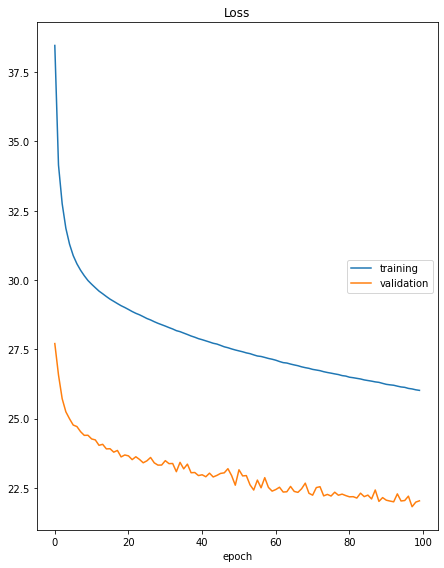

Loss
	training         	 (min:   26.022, max:   38.463, cur:   26.022)
	validation       	 (min:   21.824, max:   27.710, cur:   22.038)
360/360 [==============================] - 1s 4ms/step - loss: 26.0215 - val_loss: 22.0376


In [ ]:
#Baseline MLP
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(1, activation='relu'))

model.compile(optimizer='adam', loss='mse')

early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# custom_callback = TrainingTimeCallback()

history = model.fit(X_train,
                    y_train_CNT,
                    validation_data=(X_val, y_val_CNT),
                    batch_size = 1024, ####
                    epochs=100,
                    verbose=1,
                    callbacks=[PlotLossesKeras(), early_stopping_monitor],
                    shuffle = True)

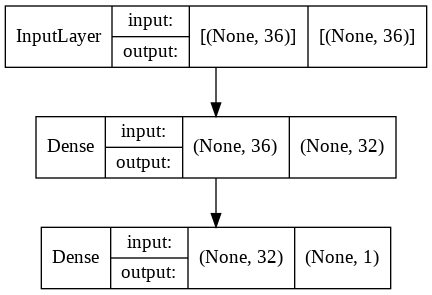

In [ ]:
keras.utils.plot_model(model, show_layer_names=False, show_shapes=True)

In [ ]:
pred_train_CNT = model.predict(X_train, batch_size=1024)
pred_val_CNT = model.predict(X_val, batch_size=1024)
pred_test_CNT = model.predict(X_test, batch_size=1024)

mse_train = mean_squared_error(pred_train_CNT, y_train_CNT)
mse_val = mean_squared_error(pred_val_CNT, y_val_CNT)
mse_test = mean_squared_error(pred_test_CNT, y_test_CNT)

print('Train MSE = {}'.format(np.round(mse_train,4)))
print('Validation MSE = {}'.format(np.round(mse_val,4)))
print('Test MSE = {}'.format(np.round(mse_test,4)))

r2_train = r2_score(y_train_CNT, pred_train_CNT)
r2_val = r2_score(y_val_CNT, pred_val_CNT)
r2_test = r2_score(y_test_CNT, pred_test_CNT)

print('\nTrain R² = {}'.format(np.round(r2_train,4)))
print('Validation R² = {}'.format(np.round(r2_val,4)))
print('Test R² = {}'.format(np.round(r2_test,4)))

Train MSE = 25.9579
Validation MSE = 22.0376
Test MSE = 24.481

Train R² = 0.4045
Validation R² = 0.3394
Test R² = 0.3661


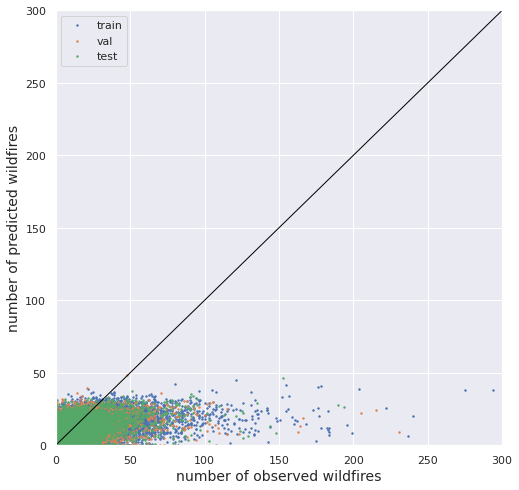

In [ ]:
sns.set()
fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(y_train_CNT,pred_train_CNT, s=2, label='train')
ax.scatter(y_val_CNT,pred_val_CNT, s=2, label='val')
ax.scatter(y_test_CNT,pred_test_CNT, s=2, label='test')
# ax.set_title('Training Data', fontsize=18)
ax.set_xlabel('number of observed wildfires', fontsize=14)
ax.set_ylabel('number of predicted wildfires', fontsize=14)
ax.plot([0, 300], [0, 300], color = 'black', linewidth=1.0)
ax.set_xlim(0,300)
ax.set_ylim(0,300)

plt.legend()
plt.show()

### BA

In [ ]:
#Baseline MLP
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(1, activation='relu'))

model.compile(optimizer='adam', loss='mse')

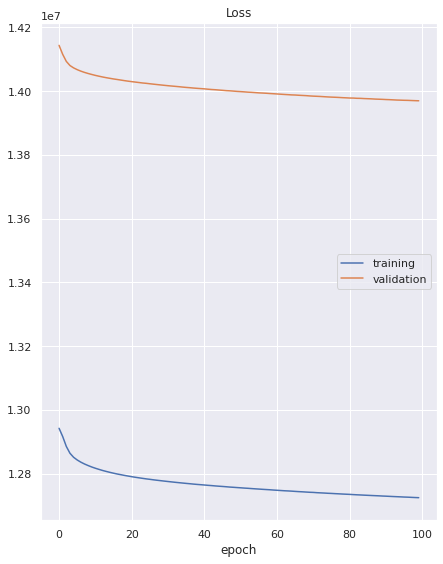

Loss
	training         	 (min: 12724544.000, max: 12942314.000, cur: 12724544.000)
	validation       	 (min: 13969987.000, max: 14143968.000, cur: 13969987.000)
360/360 [==============================] - 2s 5ms/step - loss: 12724544.0000 - val_loss: 13969987.0000


In [ ]:
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# custom_callback = TrainingTimeCallback()

history = model.fit(X_train,
                    y_train_BA,
                    validation_data=(X_val, y_val_BA),
                    batch_size = 1024,
                    epochs=100,
                    verbose=1,
                    callbacks=[PlotLossesKeras(), early_stopping_monitor],
                    shuffle = True)

In [ ]:
pred_train_BA = model.predict(X_train, batch_size=1024)
pred_val_BA = model.predict(X_val, batch_size=1024)
pred_test_BA = model.predict(X_test, batch_size=1024)

mse_train = mean_squared_error(pred_train_BA, y_train_BA)
mse_val = mean_squared_error(pred_val_BA, y_val_BA)
mse_test = mean_squared_error(pred_test_BA, y_test_BA)

print('Train MSE = {}'.format(np.round(mse_train,4)))
print('Validation MSE = {}'.format(np.round(mse_val,4)))
print('Test MSE = {}'.format(np.round(mse_test,4)))

r2_train = r2_score(y_train_BA, pred_train_BA)
r2_val = r2_score(y_val_BA, pred_val_BA)
r2_test = r2_score(y_test_BA, pred_test_BA)

print('\nTrain R² = {}'.format(np.round(r2_train,4)))
print('Validation R² = {}'.format(np.round(r2_val,4)))
print('Test R² = {}'.format(np.round(r2_test,4)))

Train MSE = 12723862.1612
Validation MSE = 13969985.5599
Test MSE = 11465187.6446

Train R² = 0.015
Validation R² = 0.0118
Test R² = 0.0019


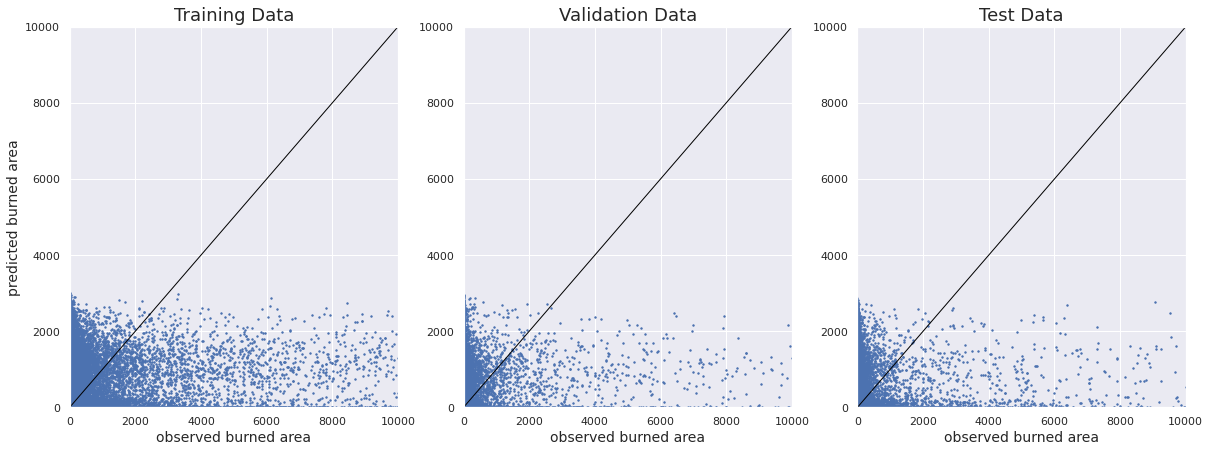

In [ ]:
sns.set()
fig, ax = plt.subplots(ncols=3, figsize=(20,7))

ax[0].scatter(y_train_BA,pred_train_BA, s=2)
ax[0].set_title('Training Data', fontsize=18)
ax[0].set_xlabel('observed burned area', fontsize=14)
ax[0].set_ylabel('predicted burned area', fontsize=14)
ax[0].plot([0, 10000], [0, 10000], color = 'black', linewidth=1.0)
ax[0].set_xlim(0,10000)
ax[0].set_ylim(0,10000)

ax[1].scatter(y_val_BA,pred_val_BA, s=2)
ax[1].set_title('Validation Data', fontsize=18)
ax[1].set_xlabel('observed burned area', fontsize=14)
# ax[1].set_ylabel('number of predicted wildfires', fontsize=14)
ax[1].plot([0, 10000], [0, 10000], color = 'black', linewidth=1.0)
ax[1].set_xlim(0,10000)
ax[1].set_ylim(0,10000)

ax[2].scatter(y_test_BA,pred_test_BA, s=2)
ax[2].set_title('Test Data', fontsize=18)
ax[2].set_xlabel('observed burned area', fontsize=14)
# ax[2].set_ylabel('number of predicted wildfires', fontsize=14)
ax[2].plot([0, 10000], [0, 10000], color = 'black', linewidth=1.0)
ax[2].set_xlim(0,10000)
ax[2].set_ylim(0,10000)

plt.show()

## Hyperparameter Optimization MLP

### CNT

In [ ]:
def build_model(hp):
    model = keras.Sequential()

    for i in range(hp.Int("num_layers", 1, 3)):
      if i == 1:
        model.add(Dense(
                    # Define the hyperparameter.
                    units=hp.Choice(f"units_{i}", [32, 128, 512]),
                    input_dim=X_train.shape[1],
                    activation="relu",
                    )
              )
        model.add(Dropout(rate=hp.Choice('dropout', values=[0.0, 0.25, 0.5])))
      else:
        model.add(
                Dense(
                # Tune number of units separately.
                units=hp.Choice(f"units_{i}", [32, 128, 512]),
                activation='relu'
                )
            )
        model.add(Dropout(rate=hp.Choice('dropout', values=[0.0, 0.25, 0.5])))
    model.add(Dense(1, activation="relu"))
    model.compile(
        optimizer="adam", loss="mse",
    )
    return model

In [ ]:
timestamp = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
log_dir = "/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/hyper_parameter_tuning/tensorboard/" + timestamp

tuner = keras_tuner.Hyperband(
              hypermodel=build_model,
              objective="val_loss",
              max_epochs=50,
              factor=3,
              hyperband_iterations=3,
              directory = log_dir,
              project_name='MLP_CNT',
              logger=TensorBoardLogger(metrics=["val_loss"],logdir=log_dir)
)

early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

setup_tb(tuner)

tuner.search(X_train, y_train_CNT, batch_size=1024, epochs=50, validation_data=(X_val, y_val_CNT), callbacks=[early_stopping_monitor])

Trial 270 Complete [00h 01m 07s]
val_loss: 22.976346969604492

Best val_loss So Far: 16.773847579956055
Total elapsed time: 01h 12m 29s


In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
units_0 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 128, 512], 'ordered': True}
dropout (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.25, 0.5], 'ordered': True}
units_1 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 128, 512], 'ordered': True}
units_2 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 128, 512], 'ordered': True}


In [ ]:
tuner.results_summary()

Results summary
Results in /content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/hyper_parameter_tuning/tensorboard/2022-09-24-13-06-23/MLP_CNT
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 3
units_0: 512
dropout: 0.0
units_1: 512
units_2: 32
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0228
Score: 16.773847579956055
Trial summary
Hyperparameters:
num_layers: 3
units_0: 512
dropout: 0.0
units_1: 128
units_2: 128
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0248
Score: 16.842926025390625
Trial summary
Hyperparameters:
num_layers: 3
units_0: 512
dropout: 0.25
units_1: 32
units_2: 512
tuner/epochs: 50
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 16.886308670043945
Trial summary
Hyperparameters:
num_layers: 3
units_0: 512
dropout: 0.0
units_1: 128
units_2: 512
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 3
tuner/round: 3
tuner/trial_

In [ ]:
from tensorboard import notebook
#Load Tensorboard
%load_ext tensorboard
%tensorboard --logdir '/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/hyper_parameter_tuning/tensorboard/2022-09-24-13-06-23'

In [ ]:
best_hps=tuner.get_best_hyperparameters()[0]

# Build model
best_model = tuner.hypermodel.build(best_hps)

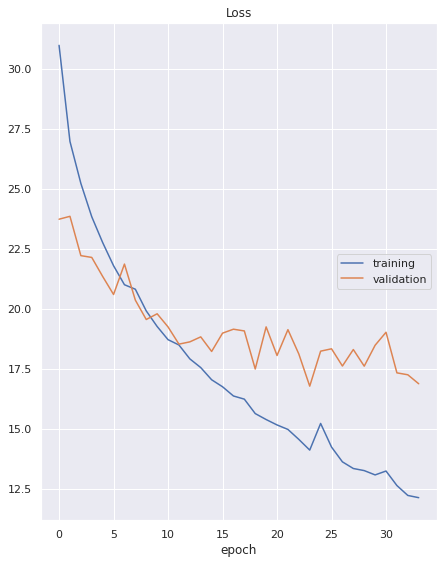

Loss
	training         	 (min:   12.139, max:   30.966, cur:   12.139)
	validation       	 (min:   16.780, max:   23.849, cur:   16.880)
360/360 [==============================] - 2s 5ms/step - loss: 12.1386 - val_loss: 16.8799


In [ ]:
best_model.fit(X_train,
               y_train_CNT,
               epochs=100,
               validation_data=(X_val, y_val_CNT),
               verbose=1,
               batch_size=1024,
               callbacks=[PlotLossesKeras(), early_stopping_monitor],
               shuffle = True)

In [ ]:
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 512)               18944     
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 512)               262656    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 32)                16416     
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [ ]:
pred_train_CNT = best_model.predict(X_train, batch_size=1024)
pred_val_CNT = best_model.predict(X_val, batch_size=1024)
pred_test_CNT = best_model.predict(X_test, batch_size=1024)

mse_train = mean_squared_error(pred_train_CNT, y_train_CNT)
mse_val = mean_squared_error(pred_val_CNT, y_val_CNT)
mse_test = mean_squared_error(pred_test_CNT, y_test_CNT)

print('Train MSE = {}'.format(np.round(mse_train,4)))
print('Validation MSE = {}'.format(np.round(mse_val,4)))
print('Test MSE = {}'.format(np.round(mse_test,4)))

r2_train = r2_score(y_train_CNT, pred_train_CNT)
r2_val = r2_score(y_val_CNT, pred_val_CNT)
r2_test = r2_score(y_test_CNT, pred_test_CNT)

print('\nTrain R² = {}'.format(np.round(r2_train,4)))
print('Validation R² = {}'.format(np.round(r2_val,4)))
print('Test R² = {}'.format(np.round(r2_test,4)))

Train MSE = 14.3195
Validation MSE = 16.7804
Test MSE = 18.2391

Train R² = 0.6715
Validation R² = 0.497
Test R² = 0.5277


In [ ]:
best_model.save('/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/Models/MLP_CNT_best')

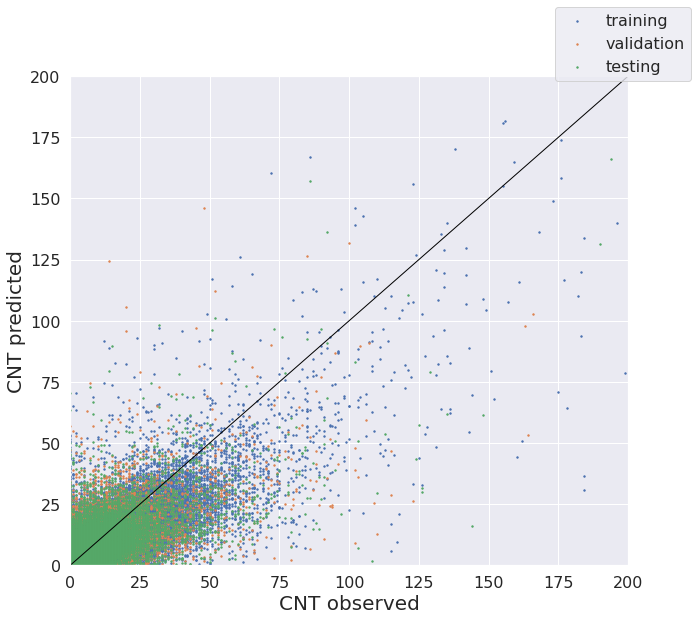

In [ ]:
fig, ax = plt.subplots(figsize=(10,9))

ax.scatter(y_train_CNT,pred_train_CNT, s=2, label='training')
ax.scatter(y_val_CNT,pred_val_CNT, s=2, label='validation')
ax.scatter(y_test_CNT,pred_test_CNT, s=2, label='testing')
# ax.set_title('Training Data', fontsize=18)
ax.set_xlabel('CNT observed', fontsize=20)
ax.set_ylabel('CNT predicted', fontsize=20)
ax.set_xlim(0,200)
ax.set_ylim(0,200)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
fig.legend(prop={'size': 16})
ax.plot([0, 300], [0, 300], color = 'black', linewidth=1.0)
plt.show()

#### with wspd

In [ ]:
#wspd
df_wspd = df.copy()
df_wspd = windspeed(df_wspd)

In [ ]:
#Split Data
data_train, data_val, data_test = split_train_test(df_wspd)

#Normalize Data
X_train, y_train_CNT, y_train_BA, means, stds = preproc(data_train)
X_val, y_val_CNT, y_val_BA, _, _ = preproc(data_val, means, stds)
X_test, y_test_CNT, y_test_BA, _, _ = preproc(data_test, means, stds)

Training years: [1993, 1994, 1996, 1999, 2000, 2001, 2002, 2005, 2006, 2007, 2008, 2009, 2010, 2014, 2015]
Test years: [1998, 2004, 2011, 2013]
Validation years: [1995, 1997, 2003, 2012]


In [ ]:
best_hps=tuner.get_best_hyperparameters()[0]

# Build model
best_model_wspd = tuner.hypermodel.build(best_hps)

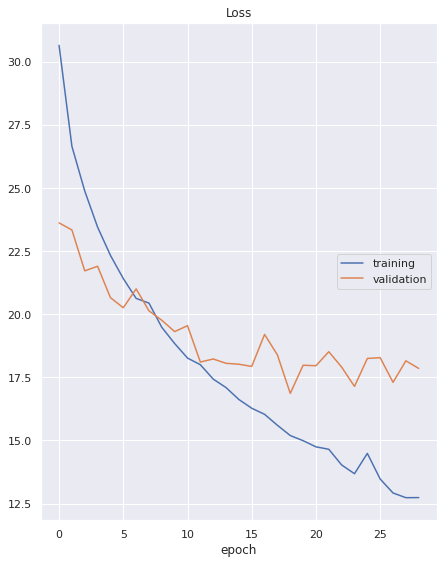

Loss
	training         	 (min:   12.731, max:   30.656, cur:   12.735)
	validation       	 (min:   16.864, max:   23.620, cur:   17.853)
360/360 [==============================] - 2s 7ms/step - loss: 12.7349 - val_loss: 17.8528


In [ ]:
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = best_model_wspd.fit(X_train,
                    y_train_CNT,
                    validation_data=(X_val, y_val_CNT),
                    batch_size = 1024,
                    epochs=100,
                    verbose=1,
                    callbacks=[PlotLossesKeras(), early_stopping_monitor],
                    shuffle = True)

In [ ]:
pred_train_CNT = best_model_wspd.predict(X_train, batch_size=1024)
pred_val_CNT = best_model_wspd.predict(X_val, batch_size=1024)
pred_test_CNT = best_model_wspd.predict(X_test, batch_size=1024)

mse_train = mean_squared_error(pred_train_CNT, y_train_CNT)
mse_val = mean_squared_error(pred_val_CNT, y_val_CNT)
mse_test = mean_squared_error(pred_test_CNT, y_test_CNT)

print('Train MSE = {}'.format(np.round(mse_train,4)))
print('Validation MSE = {}'.format(np.round(mse_val,4)))
print('Test MSE = {}'.format(np.round(mse_test,4)))

r2_train = r2_score(y_train_CNT, pred_train_CNT)
r2_val = r2_score(y_val_CNT, pred_val_CNT)
r2_test = r2_score(y_test_CNT, pred_test_CNT)

print('\nTrain R² = {}'.format(np.round(r2_train,4)))
print('Validation R² = {}'.format(np.round(r2_val,4)))
print('Test R² = {}'.format(np.round(r2_test,4)))

Train MSE = 14.1269
Validation MSE = 16.8636
Test MSE = 19.9425

Train R² = 0.6759
Validation R² = 0.4945
Test R² = 0.4836


In [ ]:
# worse performance with windspeed

#### deeper

In [ ]:
model = Sequential()
model.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='relu'))

model.compile(optimizer='adam', loss='mse')

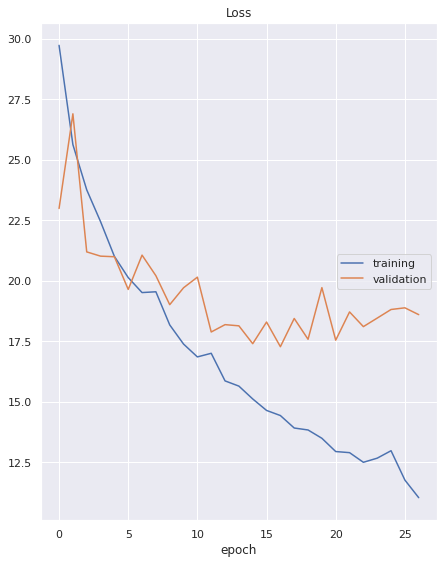

Loss
	training         	 (min:   11.033, max:   29.726, cur:   11.033)
	validation       	 (min:   17.272, max:   26.897, cur:   18.597)
360/360 [==============================] - 2s 7ms/step - loss: 11.0331 - val_loss: 18.5969


In [ ]:
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train,
                    y_train_CNT,
                    validation_data=(X_val, y_val_CNT),
                    batch_size = 1024,
                    epochs=100,
                    verbose=1,
                    callbacks=[PlotLossesKeras(), early_stopping_monitor],
                    shuffle = True)

In [ ]:
pred_train_CNT = model.predict(X_train, batch_size=1024)
pred_val_CNT = model.predict(X_val, batch_size=1024)
pred_test_CNT = model.predict(X_test, batch_size=1024)

mse_train = mean_squared_error(pred_train_CNT, y_train_CNT)
mse_val = mean_squared_error(pred_val_CNT, y_val_CNT)
mse_test = mean_squared_error(pred_test_CNT, y_test_CNT)

print('Train MSE = {}'.format(np.round(mse_train,4)))
print('Validation MSE = {}'.format(np.round(mse_val,4)))
print('Test MSE = {}'.format(np.round(mse_test,4)))

r2_train = r2_score(y_train_CNT, pred_train_CNT)
r2_val = r2_score(y_val_CNT, pred_val_CNT)
r2_test = r2_score(y_test_CNT, pred_test_CNT)

print('\nTrain R² = {}'.format(np.round(r2_train,4)))
print('Validation R² = {}'.format(np.round(r2_val,4)))
print('Test R² = {}'.format(np.round(r2_test,4)))

Train MSE = 13.0606
Validation MSE = 17.2724
Test MSE = 18.9573

Train R² = 0.7004
Validation R² = 0.4823
Test R² = 0.5091


In [ ]:
# not better

### BA

In [ ]:
timestamp = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
log_dir = "/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/hyper_parameter_tuning/tensorboard/" + timestamp

tuner = keras_tuner.Hyperband(
              hypermodel=build_model,
              objective="val_loss",
              max_epochs=50,
              factor=3,
              hyperband_iterations=3,
              directory = log_dir,
              project_name='MLP_BA',
              logger=TensorBoardLogger(metrics=["val_loss"],logdir=log_dir)
)

early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

setup_tb(tuner)

tuner.search(X_train, y_train_BA, batch_size=1024, epochs=50, validation_data=(X_val, y_val_BA), callbacks=[early_stopping_monitor])

Trial 270 Complete [00h 01m 23s]
val_loss: 14002522.0

Best val_loss So Far: 13780501.0
Total elapsed time: 01h 17m 44s


In [ ]:
tuner.results_summary()

Results summary
Results in /content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/hyper_parameter_tuning/tensorboard/2022-09-24-15-26-36/MLP_BA
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 3
units_0: 32
dropout: 0.25
units_1: 512
units_2: 512
tuner/epochs: 17
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 13780501.0
Trial summary
Hyperparameters:
num_layers: 3
units_0: 512
dropout: 0.5
units_1: 512
units_2: 128
tuner/epochs: 50
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 13791793.0
Trial summary
Hyperparameters:
num_layers: 3
units_0: 128
dropout: 0.25
units_1: 128
units_2: 512
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0138
Score: 13794827.0
Trial summary
Hyperparameters:
num_layers: 3
units_0: 512
dropout: 0.5
units_1: 128
units_2: 512
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0229
Score: 13801292.0
Trial summary
Hype

In [ ]:
from tensorboard import notebook
#Load Tensorboard
%load_ext tensorboard
%tensorboard --logdir '/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/hyper_parameter_tuning/tensorboard/2022-09-24-15-26-36'

In [ ]:
best_hps=tuner.get_best_hyperparameters()[0]

# Build model
best_model = tuner.hypermodel.build(best_hps)

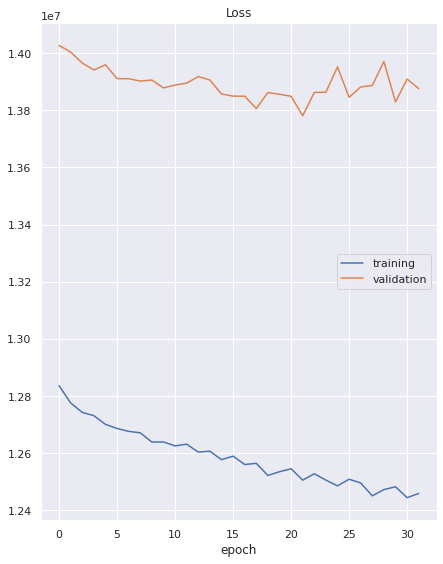

Loss
	training         	 (min: 12444808.000, max: 12836688.000, cur: 12459644.000)
	validation       	 (min: 13780741.000, max: 14027226.000, cur: 13875588.000)
360/360 [==============================] - 2s 6ms/step - loss: 12459644.0000 - val_loss: 13875588.0000


In [ ]:
best_model.fit(X_train,
               y_train_BA,
               epochs=100,
               validation_data=(X_val, y_val_BA),
               verbose=1,
               batch_size=1024,
               callbacks=[PlotLossesKeras(), early_stopping_monitor],
               shuffle = True)

In [ ]:
pred_train_BA = best_model.predict(X_train, batch_size=1024)
pred_val_BA = best_model.predict(X_val, batch_size=1024)
pred_test_BA = best_model.predict(X_test, batch_size=1024)

mse_train = mean_squared_error(pred_train_BA, y_train_BA)
mse_val = mean_squared_error(pred_val_BA, y_val_BA)
mse_test = mean_squared_error(pred_test_BA, y_test_BA)

print('Train MSE = {}'.format(np.round(mse_train,4)))
print('Validation MSE = {}'.format(np.round(mse_val,4)))
print('Test MSE = {}'.format(np.round(mse_test,4)))

r2_train = r2_score(y_train_BA, pred_train_BA)
r2_val = r2_score(y_val_BA, pred_val_BA)
r2_test = r2_score(y_test_BA, pred_test_BA)

print('\nTrain R² = {}'.format(np.round(r2_train,4)))
print('Validation R² = {}'.format(np.round(r2_val,4)))
print('Test R² = {}'.format(np.round(r2_test,4)))

Train MSE = 12447851.729
Validation MSE = 13780741.9467
Test MSE = 11384588.1937

Train R² = 0.0364
Validation R² = 0.0252
Test R² = 0.009


In [ ]:
best_model.save('/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/Models/MLP_BA_best')

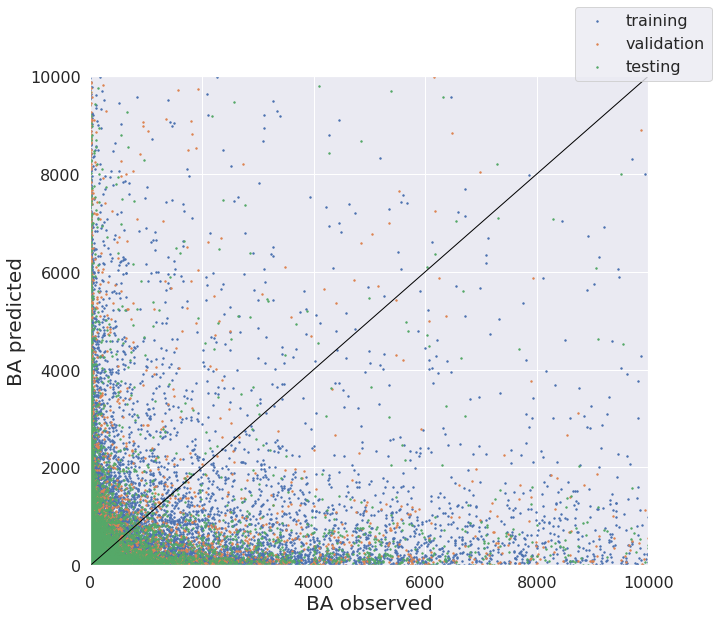

In [ ]:
sns.set()
fig, ax = plt.subplots(figsize=(10,9))

ax.scatter(y_train_BA,pred_train_BA, s=2, label='training')
ax.scatter(y_val_BA,pred_val_BA, s=2, label='validation')
ax.scatter(y_test_BA,pred_test_BA, s=2, label='testing')
# ax.set_title('Training Data', fontsize=18)
ax.set_xlabel('BA observed', fontsize=20)
ax.set_ylabel('BA predicted', fontsize=20)
ax.set_xlim(0,10000)
ax.set_ylim(0,10000)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
fig.legend(prop={'size': 16})
ax.plot([0, 10000], [0, 10000], color = 'black', linewidth=1.0)
plt.show()

#### deeper

In [ ]:
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='relu'))

model.compile(optimizer='adam', loss='mse')

In [ ]:
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
model.fit(X_train,
          y_train_BA,
          epochs=100,
          validation_data=(X_val, y_val_BA),
          verbose=1,
          batch_size=1024,
          callbacks=[PlotLossesKeras(), early_stopping_monitor],
          shuffle = True)

In [ ]:
pred_train_BA = model.predict(X_train, batch_size=1024)
pred_val_BA = model.predict(X_val, batch_size=1024)
pred_test_BA = model.predict(X_test, batch_size=1024)

mse_train = mean_squared_error(pred_train_BA, y_train_BA)
mse_val = mean_squared_error(pred_val_BA, y_val_BA)
mse_test = mean_squared_error(pred_test_BA, y_test_BA)

print('Train MSE = {}'.format(np.round(mse_train,4)))
print('Validation MSE = {}'.format(np.round(mse_val,4)))
print('Test MSE = {}'.format(np.round(mse_test,4)))

Train MSE = 12476111.953
Validation MSE = 13839681.4555
Test MSE = 11440656.4459


# CNN

## Data Preparation

In [ ]:
coordinates = data[(data.year==1993) & (data.month==3)].loc[:,'lon':'lat']
grid_points = coordinates.apply(lambda srs: Point(float(srs['lon']), float(srs['lat'])),axis='columns')
gdf = gpd.GeoDataFrame(geometry=grid_points)
lon_min, lat_min, lon_max, lat_max= gdf.total_bounds
x_cells = int((lon_max-lon_min)*2+1) #2 cells per degree
y_cells = int((lat_max-lat_min)*2+1)

/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [ ]:
#construct array of entire grid (positional array)
l=[]

for y in np.arange(lat_max, lat_min-0.5, -0.5):
  for x in np.arange(lon_min, lon_max+0.5, 0.5):
    try:
      l.append(coordinates[(coordinates.lon == x) & (coordinates.lat == y)].index[0])
    except IndexError:
      l.append(-1)

pos_arr = np.array(l).reshape((y_cells,x_cells))

In [ ]:
pos_arr[:8,:6]

array([[ -1,  -1,  -1,  -1,  -1,  -1],
       [ -1,  -1,  -1,  -1,   2,   3],
       [ 62,  63,  64,  65,  66,  67],
       [ -1, 137, 138, 139, 140, 141],
       [ -1, 214, 215, 216, 217, 218],
       [ -1,  -1, 298, 299, 300, 301],
       [ -1,  -1, 383, 384, 385, 386],
       [ -1,  -1, 470, 471, 472, 473]])

In [ ]:
#flag every instance with x and y position
grid_x = []
grid_y = []

for i in range(3503):
  grid_x.append(np.where(pos_arr == i)[1][0])
  grid_y.append(np.where(pos_arr == i)[0][0])

In [ ]:
df = transform_month(data, drop=False)
df['grid_x'] = pd.Series(np.tile(grid_x, 161))
df['grid_y'] = pd.Series(np.tile(grid_y, 161))

In [ ]:
#Split Data
data_train, data_val, data_test = split_train_test(df)

#Normalize Data
X_train, y_train_CNT, y_train_BA, means, stds = preproc(data_train)
X_val, y_val_CNT, y_val_BA, _, _ = preproc(data_val, means, stds)
X_test, y_test_CNT, y_test_BA, _, _ = preproc(data_test, means, stds)

Training years: [1993, 1994, 1996, 1999, 2000, 2001, 2002, 2005, 2006, 2007, 2008, 2009, 2010, 2014, 2015]
Test years: [1998, 2004, 2011, 2013]
Validation years: [1995, 1997, 2003, 2012]


In [ ]:
def fill_grid(X_data, df, save, name):

  array = np.zeros((len(X_data), 11, 11, X_data.shape[1]-3))  #initialize date tensor

  counter = 0
  c=1
  p=0

  for i in X_data.index:
    x = X_data.loc[i,'grid_x']  #coordinates of datapoint on grid
    y = X_data.loc[i,'grid_y']

    if counter == 3503:
      print('Month: {}'.format(c))
      c+=1
      counter=0
    counter+=1

    for j in range(x-5,x+6):    #every cell in the surrounding 11x11 vicinity
      for k in range(y-5,y+6):

        if (0 <= j < 117) & (0 <= k < 49):  #cell outside of grid?
          cell = pos_arr[k,j]               #position of cell in dataframe in first period

          if cell != -1:    #cell outside of continetal united states?
            f = (df.loc[i,'year']-1993)*7+(df.loc[i,'month']-3) #number of month gone by
            l = cell + 3503*f                                   #actual position in dataframe
            array[p,k-y+5,j-x+5,:] = X_data.loc[l,:'month_cos'].drop('month')    #fill tensor

    p += 1

  if save == True:
    try:
      timestamp = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
      save_dir = "/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/saved_arrays_for_CNN/"
      with open(save_dir + name + '_' + timestamp, 'wb') as f:
        pickle.dump((array), f, protocol=4)
    except Exception:
      print('array too big')

  return array

In [ ]:
X_train = fill_grid(X_train, data_train, save=True, name='Training')

In [ ]:
X_val_CNN = fill_grid(X_val, data_val, save=True, name='Validation')

In [ ]:
X_test_CNN = fill_grid(X_test, data_test, save=True, name='Testing')

## Training

In [ ]:
#only necessary to get labels

#Split Data
data_train, data_val, data_test = split_train_test(data)

#Normalize Data
_, y_train_CNT, y_train_BA, means, stds = preproc(data_train)
_, y_val_CNT, y_val_BA, _, _ = preproc(data_val, means, stds)
_, y_test_CNT, y_test_BA, _, _ = preproc(data_test, means, stds)

Training years: [1993, 1994, 1996, 1999, 2000, 2001, 2002, 2005, 2006, 2007, 2008, 2009, 2010, 2014, 2015]
Test years: [1998, 2004, 2011, 2013]
Validation years: [1995, 1997, 2003, 2012]


In [ ]:
with open("/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/saved_arrays_for_CNN/"+'Training_2022-09-25-20-02-26', 'rb') as f:
    X_train = pickle.load(f)

In [ ]:
with open("/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/saved_arrays_for_CNN/"+'Validation_2022-09-25-11-38-14', 'rb') as f:
    X_val = pickle.load(f)

In [ ]:
with open("/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/saved_arrays_for_CNN/"+'Testing_2022-09-25-22-25-19', 'rb') as f:
    X_test = pickle.load(f)

In [ ]:
# first try
model = Sequential()
model.add(Conv2D(filters=64,
                  kernel_size=5,
                  padding='valid',
                  activation='relu',
                  input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])
                  ))
model.add(Dropout(0.5))
model.add(Conv2D(filters=128,
                  kernel_size=3,
                  padding='valid',
                  activation='relu'#,
                  #input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])
                  ))
model.add(Dropout(0.5))
model.add(Conv2D(filters=256,
                  kernel_size=3,
                  padding='valid',
                  activation='relu'#,
                  #input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])
                  ))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1, activation='relu'))

model.compile(optimizer='adam', loss='mse')

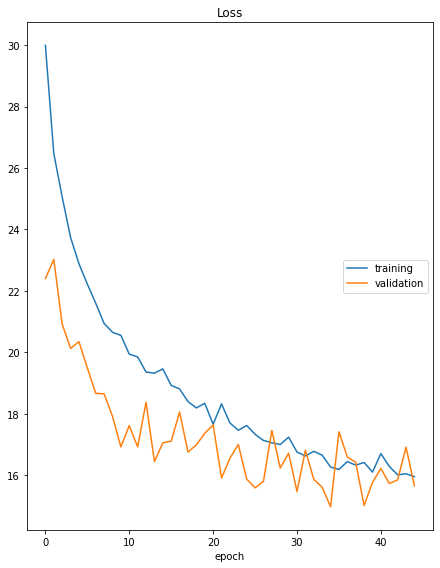

Loss
	training         	 (min:   15.955, max:   29.988, cur:   15.955)
	validation       	 (min:   14.976, max:   23.029, cur:   15.660)
360/360 [==============================] - 6s 16ms/step - loss: 15.9545 - val_loss: 15.6597


In [ ]:
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train,
                    y_train_CNT,
                    validation_data=(X_val, y_val_CNT),
                    batch_size = 1024,
                    epochs=100,
                    verbose=1,
                    callbacks=[PlotLossesKeras(), early_stopping_monitor],
                    shuffle = True)

In [ ]:
# if GPU RAM is too full model has to be saved, runtime restarted and then the model can be evaluated

In [ ]:
timestamp = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
model.save('/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/Models/CNN_'+timestamp)

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/Models/CNN_2022-09-25-23-20-21')

In [ ]:
pred_train_CNT = model.predict(X_train, batch_size=1024)
pred_val_CNT = model.predict(X_val, batch_size=1024)
pred_test_CNT = model.predict(X_test, batch_size=1024)

mse_train = mean_squared_error(pred_train_CNT, y_train_CNT)
mse_val = mean_squared_error(pred_val_CNT, y_val_CNT)
mse_test = mean_squared_error(pred_test_CNT, y_test_CNT)

print('Train MSE = {}'.format(np.round(mse_train,4)))
print('Validation MSE = {}'.format(np.round(mse_val,4)))
print('Test MSE = {}'.format(np.round(mse_test,4)))

r2_train = r2_score(y_train_CNT, pred_train_CNT)
r2_val = r2_score(y_val_CNT, pred_val_CNT)
r2_test = r2_score(y_test_CNT, pred_test_CNT)

print('\nTrain R² = {}'.format(np.round(r2_train,4)))
print('Validation R² = {}'.format(np.round(r2_val,4)))
print('Test R² = {}'.format(np.round(r2_test,4)))

## Hyperparameter Optimization CNN

In [ ]:
def build_model_CNN(hp):
    model = keras.Sequential()

    for i in range(hp.Int("num_layers", 1, 3)):
      if i == 1:
        model.add(Conv2D(filters=hp.Choice(f"filters{i}", [32, 128, 512]),
                  kernel_size=3,
                  padding='valid',
                  activation='relu',
                  input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])
                  ))
        model.add(Dropout(rate=hp.Choice('dropout', values=[0.0, 0.25, 0.5])))
      else:
        model.add(Conv2D(filters=hp.Choice(f"filters{i}", [32, 128, 512]),
                  kernel_size=3,
                  padding='valid',
                  activation='relu'
                  ))
        model.add(Dropout(rate=hp.Choice('dropout', values=[0.0, 0.25, 0.5])))

    model.add(Flatten())
    model.add(Dense(1, activation="relu"))
    model.compile(
        optimizer="adam", loss="mse",
    )
    return model

### CNT

In [ ]:
timestamp = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
log_dir = "/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/hyper_parameter_tuning/tensorboard/" + timestamp

tuner = keras_tuner.Hyperband(
              hypermodel=build_model_CNN,
              objective="val_loss",
              max_epochs=50,
              factor=3,
              hyperband_iterations=3,
              directory = log_dir,
              project_name='CNN_CNT',
              logger=TensorBoardLogger(metrics=["val_loss"],logdir=log_dir)
)

early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

setup_tb(tuner)

tuner.search(X_train, y_train_CNT, batch_size=1024, epochs=50, validation_data=(X_val, y_val_CNT), callbacks=[early_stopping_monitor])

Trial 270 Complete [00h 02m 55s]
val_loss: 16.62826156616211

Best val_loss So Far: 13.817188262939453
Total elapsed time: 06h 29m 51s


In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
filters0 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 128, 512], 'ordered': True}
dropout (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.25, 0.5], 'ordered': True}
filters1 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 128, 512], 'ordered': True}
filters2 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 128, 512], 'ordered': True}


In [ ]:
tuner.results_summary()

Results summary
Results in /content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/hyper_parameter_tuning/tensorboard/2022-09-25-23-39-21/CNN_CNT
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 3
filters0: 32
dropout: 0.25
filters1: 128
filters2: 512
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0259
Score: 13.817188262939453
Trial summary
Hyperparameters:
num_layers: 2
filters0: 32
dropout: 0.25
filters1: 512
filters2: 128
tuner/epochs: 50
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 14.021492958068848
Trial summary
Hyperparameters:
num_layers: 3
filters0: 512
dropout: 0.25
filters1: 128
filters2: 128
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0249
Score: 14.05710506439209
Trial summary
Hyperparameters:
num_layers: 2
filters0: 128
dropout: 0.25
filters1: 512
filters2: 32
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 2
tuner/round: 2

In [ ]:
#Load Tensorboard
%load_ext tensorboard
%tensorboard --logdir '/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/hyper_parameter_tuning/tensorboard/2022-09-25-23-39-21'

In [ ]:
best_hps=tuner.get_best_hyperparameters()[0]

# Build model
best_model = tuner.hypermodel.build(best_hps)

In [ ]:
best_model.save('/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/Models/CNN_CNT_best)

In [ ]:
best_model = keras.models.load_model('/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/Models/CNN_CNT_best')

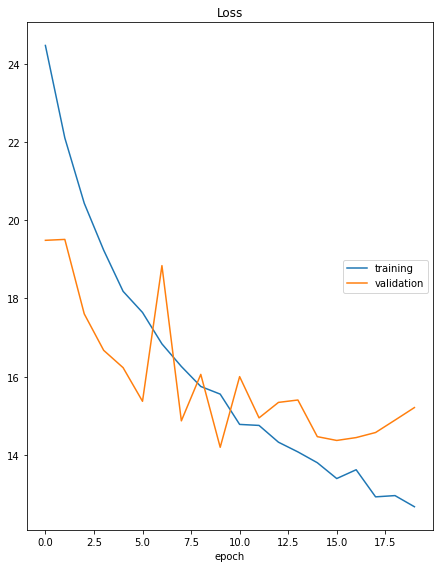

Loss
	training         	 (min:   12.677, max:   24.467, cur:   12.677)
	validation       	 (min:   14.196, max:   19.510, cur:   15.212)
360/360 [==============================] - 8s 23ms/step - loss: 12.6767 - val_loss: 15.2117


In [ ]:
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

best_model.fit(X_train,
               y_train_CNT,
               epochs=100,
               validation_data=(X_val, y_val_CNT),
               verbose=1,
               batch_size=1024,
               callbacks=[PlotLossesKeras(), early_stopping_monitor],
               shuffle = True)

In [ ]:
best_model.save('/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/Models/CNN_CNT_best')

In [ ]:
best_model = keras.models.load_model('/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/Models/CNN_CNT_best')

In [ ]:
pred_train_CNT = best_model.predict(X_train, batch_size=1024)
pred_val_CNT = best_model.predict(X_val, batch_size=1024)
pred_test_CNT = best_model.predict(X_test, batch_size=1024)

mse_train = mean_squared_error(pred_train_CNT, y_train_CNT)
mse_val = mean_squared_error(pred_val_CNT, y_val_CNT)
mse_test = mean_squared_error(pred_test_CNT, y_test_CNT)

print('Train MSE = {}'.format(np.round(mse_train,4)))
print('Validation MSE = {}'.format(np.round(mse_val,4)))
print('Test MSE = {}'.format(np.round(mse_test,4)))

r2_train = r2_score(y_train_CNT, pred_train_CNT)
r2_val = r2_score(y_val_CNT, pred_val_CNT)
r2_test = r2_score(y_test_CNT, pred_test_CNT)

print('\nTrain R² = {}'.format(np.round(r2_train,4)))
print('Validation R² = {}'.format(np.round(r2_val,4)))
print('Test R² = {}'.format(np.round(r2_test,4)))

Train MSE = 13.906
Validation MSE = 14.1961
Test MSE = 16.6803

Train R² = 0.681
Validation R² = 0.5745
Test R² = 0.5681


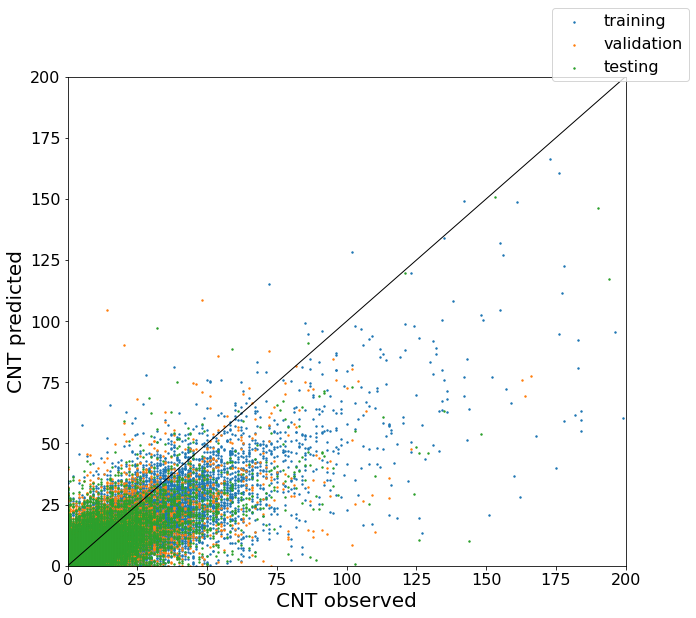

In [ ]:
fig, ax = plt.subplots(figsize=(10,9))

ax.scatter(y_train_CNT,pred_train_CNT, s=2, label='training')
ax.scatter(y_val_CNT,pred_val_CNT, s=2, label='validation')
ax.scatter(y_test_CNT,pred_test_CNT, s=2, label='testing')
# ax.set_title('Training Data', fontsize=18)
ax.set_xlabel('CNT observed', fontsize=20)
ax.set_ylabel('CNT predicted', fontsize=20)
ax.set_xlim(0,200)
ax.set_ylim(0,200)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
fig.legend(prop={'size': 16})
ax.plot([0, 300], [0, 300], color = 'black', linewidth=1.0)
plt.show()

#### deeper

In [ ]:
model = Sequential()
model.add(Conv2D(filters=32,
                  kernel_size=5,
                  padding='valid',
                  activation='relu',
                  input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])
                  ))
model.add(Dropout(0.25))
model.add(Conv2D(filters=128,
                  kernel_size=3,
                  padding='valid',
                  activation='relu'#,
                  #input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])
                  ))
model.add(Dropout(0.25))
model.add(Conv2D(filters=512,
                  kernel_size=3,
                  padding='valid',
                  activation='relu'#,
                  #input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])
                  ))
model.add(Dropout(0.25))
model.add(Conv2D(filters=1024,
                  kernel_size=3,
                  padding='valid',
                  activation='relu'#,
                  #input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])
                  ))
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(1, activation='relu'))

model.compile(optimizer='adam', loss='mse')

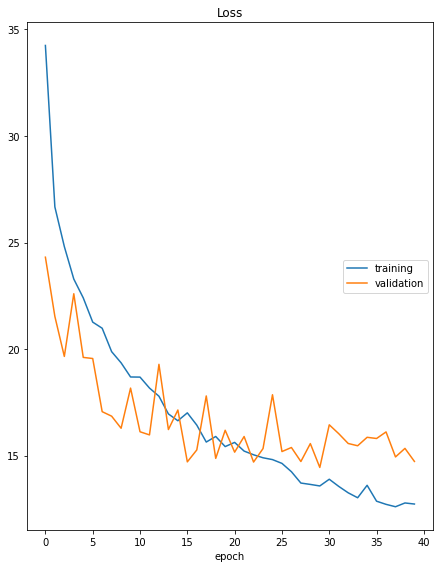

Loss
	training         	 (min:   12.604, max:   34.251, cur:   12.730)
	validation       	 (min:   14.447, max:   24.314, cur:   14.730)
360/360 [==============================] - 9s 25ms/step - loss: 12.7304 - val_loss: 14.7295


In [ ]:
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train,
                    y_train_CNT,
                    validation_data=(X_val, y_val_CNT),
                    batch_size = 1024,
                    epochs=100,
                    verbose=1,
                    callbacks=[PlotLossesKeras(), early_stopping_monitor],
                    shuffle = True)

In [ ]:
model.save('/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/Models/CNN_deeper')

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/Models/CNN_deeper')

In [ ]:
pred_train_CNT = model.predict(X_train, batch_size=1024)
pred_val_CNT = model.predict(X_val, batch_size=1024)
pred_test_CNT = model.predict(X_test, batch_size=1024)

mse_train = mean_squared_error(pred_train_CNT, y_train_CNT)
mse_val = mean_squared_error(pred_val_CNT, y_val_CNT)
mse_test = mean_squared_error(pred_test_CNT, y_test_CNT)

print('Train MSE = {}'.format(np.round(mse_train,4)))
print('Validation MSE = {}'.format(np.round(mse_val,4)))
print('Test MSE = {}'.format(np.round(mse_test,4)))

r2_train = r2_score(y_train_CNT, pred_train_CNT)
r2_val = r2_score(y_val_CNT, pred_val_CNT)
r2_test = r2_score(y_test_CNT, pred_test_CNT)

print('\nTrain R² = {}'.format(np.round(r2_train,4)))
print('Validation R² = {}'.format(np.round(r2_val,4)))
print('Test R² = {}'.format(np.round(r2_test,4)))

Train MSE = 11.3853
Validation MSE = 14.4469
Test MSE = 16.6631

Train R² = 0.7388
Validation R² = 0.567
Test R² = 0.5685


### BA

In [ ]:
timestamp = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
log_dir = "/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/hyper_parameter_tuning/tensorboard/" + timestamp

tuner = keras_tuner.Hyperband(
              hypermodel=build_model_CNN,
              objective="val_loss",
              max_epochs=50,
              factor=3,
              hyperband_iterations=3,
              directory = log_dir,
              project_name='CNN_BA',
              logger=TensorBoardLogger(metrics=["val_loss"],logdir=log_dir)
)

early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

setup_tb(tuner)

tuner.search(X_train, y_train_BA, batch_size=1024, epochs=50, validation_data=(X_val, y_val_BA), callbacks=[early_stopping_monitor])

Trial 270 Complete [00h 03m 19s]
val_loss: 13872467.0

Best val_loss So Far: 13780399.0
Total elapsed time: 05h 49m 52s


In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
filters0 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 128, 512], 'ordered': True}
dropout (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.25, 0.5], 'ordered': True}
filters1 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 128, 512], 'ordered': True}
filters2 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 128, 512], 'ordered': True}


In [ ]:
tuner.results_summary()

Results summary
Results in /content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/hyper_parameter_tuning/tensorboard/2022-09-26-14-28-25/CNN_BA
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 3
filters0: 32
dropout: 0.5
filters1: 128
filters2: 128
tuner/epochs: 17
tuner/initial_epoch: 6
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 0235
Score: 13780399.0
Trial summary
Hyperparameters:
num_layers: 2
filters0: 512
dropout: 0.25
filters1: 512
filters2: 128
tuner/epochs: 17
tuner/initial_epoch: 6
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 0059
Score: 13782352.0
Trial summary
Hyperparameters:
num_layers: 2
filters0: 128
dropout: 0.0
filters1: 512
filters2: 128
tuner/epochs: 17
tuner/initial_epoch: 6
tuner/bracket: 3
tuner/round: 2
tuner/trial_id: 0124
Score: 13784739.0
Trial summary
Hyperparameters:
num_layers: 3
filters0: 512
dropout: 0.5
filters1: 32
filters2: 512
tuner/epochs: 17
tuner/initial_epoch: 6
tuner/bracket: 3
tuner/round: 2
tuner/t

In [ ]:
#Load Tensorboard
%load_ext tensorboard
%tensorboard --logdir '/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/hyper_parameter_tuning/tensorboard/2022-09-26-14-28-25'

In [ ]:
best_hps=tuner.get_best_hyperparameters()[0]

# Build model
best_model = tuner.hypermodel.build(best_hps)

In [ ]:
best_model.save('/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/Models/CNN_best_BA')

In [ ]:
best_model = keras.models.load_model('/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/Models/CNN_best_BA')

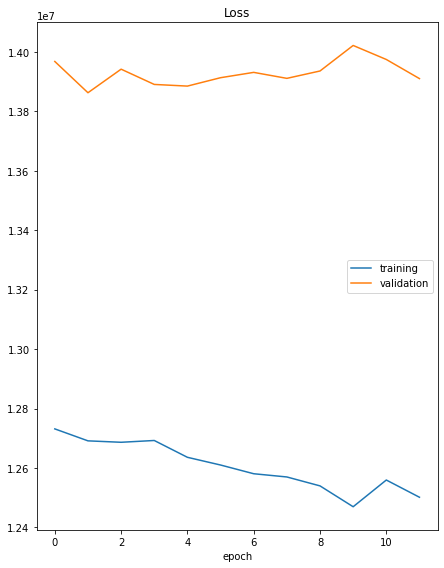

Loss
	training         	 (min: 12469358.000, max: 12731391.000, cur: 12501276.000)
	validation       	 (min: 13862882.000, max: 14022006.000, cur: 13910463.000)
360/360 [==============================] - 6s 16ms/step - loss: 12501276.0000 - val_loss: 13910463.0000


In [ ]:
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

best_model.fit(X_train,
               y_train_BA,
               epochs=100,
               validation_data=(X_val, y_val_BA),
               verbose=1,
               batch_size=1024,
               callbacks=[PlotLossesKeras(), early_stopping_monitor],
               shuffle = True)

In [ ]:
best_model.save('/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/Models/CNN_best_BA')

In [ ]:
best_model = keras.models.load_model('/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/Models/CNN_best_BA')

In [ ]:
pred_train_BA = best_model.predict(X_train, batch_size=1024)
pred_val_BA = best_model.predict(X_val, batch_size=1024)
pred_test_BA = best_model.predict(X_test, batch_size=1024)

mse_train = mean_squared_error(pred_train_BA, y_train_BA)
mse_val = mean_squared_error(pred_val_BA, y_val_BA)
mse_test = mean_squared_error(pred_test_BA, y_test_BA)

print('Train MSE = {}'.format(np.round(mse_train,4)))
print('Validation MSE = {}'.format(np.round(mse_val,4)))
print('Test MSE = {}'.format(np.round(mse_test,4)))

Train MSE = 12592374.1069
Validation MSE = 13862881.4827
Test MSE = 11417953.5968


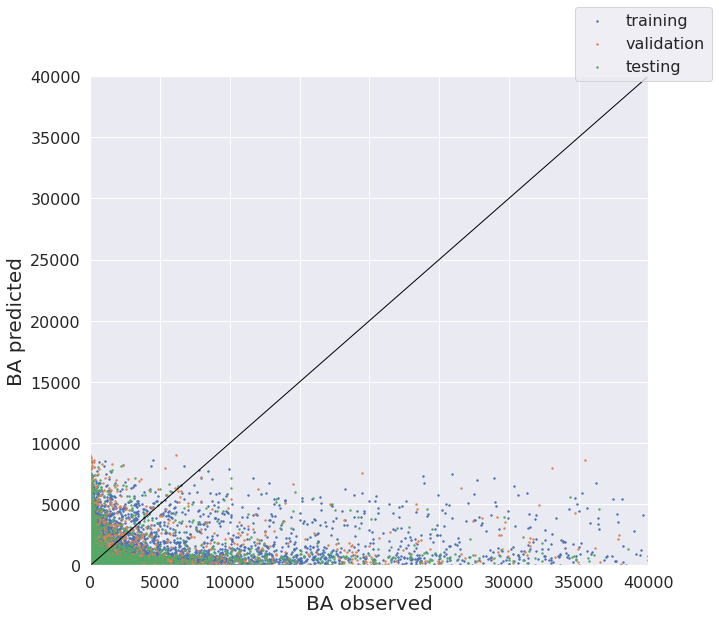

In [ ]:
sns.set()
fig, ax = plt.subplots(figsize=(10,9))

ax.scatter(y_train_BA,pred_train_BA, s=2, label='training')
ax.scatter(y_val_BA,pred_val_BA, s=2, label='validation')
ax.scatter(y_test_BA,pred_test_BA, s=2, label='testing')
# ax.set_title('Training Data', fontsize=18)
ax.set_xlabel('BA observed', fontsize=20)
ax.set_ylabel('BA predicted', fontsize=20)
ax.set_xlim(0,40000)
ax.set_ylim(0,40000)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
fig.legend(prop={'size': 16})
ax.plot([0, 40000], [0, 40000], color = 'black', linewidth=1.0)
plt.show()

#### deeper

In [ ]:
model = Sequential()
model.add(Conv2D(filters=32,
                  kernel_size=5,
                  padding='valid',
                  activation='relu',
                  input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])
                  ))
model.add(Dropout(0.5))
model.add(Conv2D(filters=128,
                  kernel_size=3,
                  padding='valid',
                  activation='relu'#,
                  #input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])
                  ))
model.add(Dropout(0.5))
model.add(Conv2D(filters=128,
                  kernel_size=3,
                  padding='valid',
                  activation='relu'#,
                  #input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])
                  ))
model.add(Dropout(0.5))
model.add(Conv2D(filters=512,
                  kernel_size=3,
                  padding='valid',
                  activation='relu'#,
                  #input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])
                  ))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1, activation='relu'))

model.compile(optimizer='adam', loss='mse')

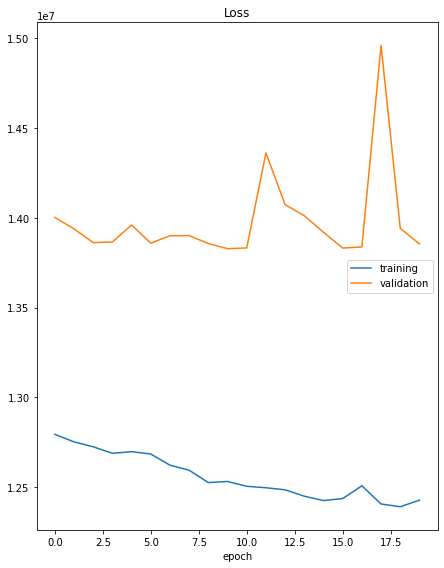

Loss
	training         	 (min: 12391348.000, max: 12794325.000, cur: 12427965.000)
	validation       	 (min: 13827445.000, max: 14958678.000, cur: 13854230.000)
360/360 [==============================] - 7s 20ms/step - loss: 12427965.0000 - val_loss: 13854230.0000


In [ ]:
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train,
                    y_train_BA,
                    validation_data=(X_val, y_val_BA),
                    batch_size = 1024,
                    epochs=100,
                    verbose=1,
                    callbacks=[PlotLossesKeras(), early_stopping_monitor],
                    shuffle = True)

In [ ]:
model.save('/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/Models/CNN_BA_deeper')

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/Models/CNN_BA_deeper')

In [ ]:
print_mse(model, X_train, X_val, X_test, y_train_BA, y_val_BA, y_test_BA)

Train MSE = 12437017.1505
Validation MSE = 13827446.8538
Test MSE = 11436430.1058


# Random Forest Regressor

In [ ]:
df = transform_month(data)

#Split Data
data_train, data_test = split_train_test(df, val=False)

#Normalize Data
X_train, y_train_CNT, y_train_BA, means, stds = preproc(data_train)
X_test, y_test_CNT, y_test_BA, _, _ = preproc(data_test, means, stds)

Training years: [1993, 1994, 1995, 1996, 1997, 1999, 2000, 2001, 2002, 2003, 2005, 2006, 2007, 2008, 2009, 2010, 2012, 2014, 2015]
Test years: [1998, 2004, 2011, 2013]


## Hyperparameter Optimization

### CNT

In [ ]:
gscv = GridSearchCV(
        estimator=RandomForestRegressor(random_state=42),
        param_grid={
            'max_depth': [5,10,15,20],
            'n_estimators': [10,50,100],
            'bootstrap': [True, False]
        },
        verbose=2, scoring='neg_mean_squared_error', n_jobs=-1)

grid_result = gscv.fit(X_train, y_train_CNT)
best_params = grid_result.best_params_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
best_params

{'bootstrap': True, 'max_depth': 20, 'n_estimators': 100}

In [ ]:
rf_CNT_gs = RandomForestRegressor(max_depth=best_params["max_depth"],
                            n_estimators=best_params["n_estimators"],
                            bootstrap=best_params["bootstrap"],
                            random_state=42,
                            verbose=1,
                            n_jobs=-1)

In [ ]:
rf_CNT_gs = RandomForestRegressor(max_depth=20,
                            n_estimators=100,
                            bootstrap=True,
                            random_state=42,
                            verbose=1,
                            n_jobs=-1)

rf_CNT_gs.fit(X_train, y_train_CNT)

print_mse_rfr(rf_CNT_gs, X_train, X_test, y_train_CNT, y_test_CNT)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s


Train MSE = 3.085
Test MSE = 15.2741


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished


In [ ]:
pickle.dump(rf_CNT_gs, open('/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/Models/RFR_CNT_20', 'wb'))

In [ ]:
rf_CNT_gs = RandomForestRegressor(max_depth=20,
                            n_estimators=50,
                            bootstrap=True,
                            random_state=42,
                            verbose=1,
                            n_jobs=-1)

rf_CNT_gs.fit(X_train, y_train_CNT)

print_mse_rfr(rf_CNT_gs, X_train, X_test, y_train_CNT, y_test_CNT)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s


Train MSE = 3.1673
Test MSE = 15.4446


[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished


In [ ]:
rf_CNT_gs = RandomForestRegressor(max_depth=15,
                            n_estimators=100,
                            bootstrap=True,
                            random_state=42,
                            verbose=1,
                            n_jobs=-1)

rf_CNT_gs.fit(X_train, y_train_CNT)

print_mse_rfr(rf_CNT_gs, X_train, X_test, y_train_CNT, y_test_CNT)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s


Train MSE = 6.8709
Test MSE = 16.1634


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


In [ ]:
pickle.dump(rf_CNT_gs, open('/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/Models/RFR_CNT_15', 'wb'))

In [ ]:
rf_CNT_gs = RandomForestRegressor(max_depth=14,
                            n_estimators=100,
                            bootstrap=True,
                            random_state=42,
                            verbose=1,
                            n_jobs=-1)

rf_CNT_gs.fit(X_train, y_train_CNT)

print_mse_rfr(rf_CNT_gs, X_train, X_test, y_train_CNT, y_test_CNT)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s


Train MSE = 8.2483
Test MSE = 16.6082


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


In [ ]:
pickle.dump(rf_CNT_gs, open('/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/Models/RFR_CNT_14', 'wb'))

In [ ]:
rf_CNT_gs = RandomForestRegressor(max_depth=13,
                            n_estimators=100,
                            bootstrap=True,
                            random_state=42,
                            verbose=1,
                            n_jobs=-1)

rf_CNT_gs.fit(X_train, y_train_CNT)

print_mse_rfr(rf_CNT_gs, X_train, X_test, y_train_CNT, y_test_CNT)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s


Train MSE = 9.8802
Test MSE = 17.1962


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


In [ ]:
pickle.dump(rf_CNT_gs, open('/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/Models/RFR_CNT_13', 'wb'))

In [ ]:
rf_CNT_gs = RandomForestRegressor(max_depth=12,
                            n_estimators=100,
                            bootstrap=True,
                            random_state=42,
                            verbose=1,
                            n_jobs=-1)

rf_CNT_gs.fit(X_train, y_train_CNT)

print_mse_rfr(rf_CNT_gs, X_train, X_test, y_train_CNT, y_test_CNT)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s


Train MSE = 11.8202
Test MSE = 18.0118


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


In [ ]:
pickle.dump(rf_CNT_gs, open('/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/Models/RFR_CNT_12', 'wb'))

In [ ]:
rf_CNT_gs = RandomForestRegressor(max_depth=11,
                            n_estimators=100,
                            bootstrap=True,
                            random_state=42,
                            verbose=1,
                            n_jobs=-1)

rf_CNT_gs.fit(X_train, y_train_CNT)

print_mse_rfr(rf_CNT_gs, X_train, X_test, y_train_CNT, y_test_CNT)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s


Train MSE = 14.0914
Test MSE = 18.9716


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


In [ ]:
pickle.dump(rf_CNT_gs, open('/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/Models/RFR_CNT_11', 'wb'))

In [ ]:
rf_CNT_gs = RandomForestRegressor(max_depth=10,
                            n_estimators=100,
                            bootstrap=True,
                            random_state=42,
                            verbose=1,
                            n_jobs=-1)

rf_CNT_gs.fit(X_train, y_train_CNT)

print_mse_rfr(rf_CNT_gs, X_train, X_test, y_train_CNT, y_test_CNT)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Train MSE = 16.6551
Test MSE = 20.0575


In [ ]:
pickle.dump(rf_CNT_gs, open('/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/Models/RFR_CNT_10', 'wb'))

In [ ]:
rf_CNT_gs = RandomForestRegressor(max_depth=20,
                            n_estimators=200,
                            bootstrap=True,
                            random_state=42,
                            verbose=1,
                            n_jobs=-1)

rf_CNT_gs.fit(X_train, y_train_CNT)

print_mse_rfr(rf_CNT_gs, X_train, X_test, y_train_CNT, y_test_CNT)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  9.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    2.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s


Train MSE = 3.05
Test MSE = 15.2759


[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.7s finished


In [ ]:
rf_CNT_gs = RandomForestRegressor(max_depth=13,
                            n_estimators=200,
                            bootstrap=True,
                            random_state=42,
                            verbose=1,
                            n_jobs=-1)

rf_CNT_gs.fit(X_train, y_train_CNT)

print_mse_rfr(rf_CNT_gs, X_train, X_test, y_train_CNT, y_test_CNT)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  6.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s


Train MSE = 9.8014
Test MSE = 17.192


[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.3s finished


### BA

In [ ]:
gscv = GridSearchCV(
        estimator=RandomForestRegressor(random_state=42),
        param_grid={
            'max_depth': [5,10,15,20],
            'n_estimators': [10,50,100],
            'bootstrap': [True, False]
        },
        verbose=1, scoring='neg_mean_squared_error', n_jobs=-1)

grid_result = gscv.fit(X_train, y_train_BA)
best_params = grid_result.best_params_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [ ]:
best_params

{'bootstrap': True, 'max_depth': 5, 'n_estimators': 100}

In [ ]:
rf_BA_gs = RandomForestRegressor(max_depth=best_params["max_depth"],
                            n_estimators=best_params["n_estimators"],
                            bootstrap=best_params["bootstrap"],
                            random_state=42,
                            verbose=1,
                            n_jobs=-1)

In [ ]:
rf_BA_gs = RandomForestRegressor(max_depth=5,
                            n_estimators=100,
                            bootstrap=True,
                            random_state=42,
                            verbose=1,
                            n_jobs=-1)

rf_BA_gs.fit(X_train, y_train_BA)

print_mse_rfr(rf_BA_gs, X_train, X_test, y_train_BA, y_test_BA)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s


Train MSE = 11753931.6086
Test MSE = 11668276.0668


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


In [ ]:
pickle.dump(rf_BA_gs, open('/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/Models/RFR_BA_5', 'wb'))

In [ ]:
rf_BA = RandomForestRegressor(max_depth=10,
                            n_estimators=100,
                            bootstrap=True,
                            random_state=42,
                            verbose=1,
                            n_jobs=-1)

rf_BA.fit(X_train, y_train_BA)

print_mse_rfr(rf_BA, X_train, X_test, y_train_BA, y_test_BA)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s


Train MSE = 7406228.9225
Test MSE = 12173271.0102


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


In [ ]:
pickle.dump(rf_BA, open('/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/Models/RFR_BA_10', 'wb'))

In [ ]:
rf_BA = RandomForestRegressor(max_depth=4,
                            n_estimators=100,
                            bootstrap=True,
                            random_state=42,
                            verbose=1,
                            n_jobs=-1)

rf_BA.fit(X_train, y_train_BA)

print_mse_rfr(rf_BA, X_train, X_test, y_train_BA, y_test_BA)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Train MSE = 12327815.0842
Test MSE = 11629975.4862


In [ ]:
pickle.dump(rf_BA, open('/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/Models/RFR_BA_4', 'wb'))

In [ ]:
rf_BA = RandomForestRegressor(max_depth=3,
                            n_estimators=100,
                            bootstrap=True,
                            random_state=42,
                            verbose=1,
                            n_jobs=-1)

rf_BA.fit(X_train, y_train_BA)

print_mse_rfr(rf_BA, X_train, X_test, y_train_BA, y_test_BA)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   52.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s


Train MSE = 12754091.1811
Test MSE = 11621829.4088


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


In [ ]:
pickle.dump(rf_BA, open('/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/Models/RFR_BA_3', 'wb'))

In [ ]:
rf_BA = RandomForestRegressor(max_depth=2,
                            n_estimators=100,
                            bootstrap=True,
                            random_state=42,
                            verbose=1,
                            n_jobs=-1)

rf_BA.fit(X_train, y_train_BA)

print_mse_rfr(rf_BA, X_train, X_test, y_train_BA, y_test_BA)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   35.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s


Train MSE = 13006251.1105
Test MSE = 11612537.9992


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


In [ ]:
pickle.dump(rf_BA, open('/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/Models/RFR_BA_2', 'wb'))

In [ ]:
rf_BA = RandomForestRegressor(max_depth=5,
                            n_estimators=200,
                            bootstrap=True,
                            random_state=42,
                            verbose=1,
                            n_jobs=-1)

rf_BA.fit(X_train, y_train_BA)

print_mse_rfr(rf_BA, X_train, X_test, y_train_BA, y_test_BA)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s


Train MSE = 11771091.7159
Test MSE = 11666865.6036


[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished


## Feature Importance

In [ ]:
df = transform_month(data)

#Split Data
data_train, data_test = split_train_test(df, val=False)

#Normalize Data
X_train, y_train_CNT, y_train_BA, means, stds = preproc(data_train)
X_test, y_test_CNT, y_test_BA, _, _ = preproc(data_test, means, stds)

Training years: [1993, 1994, 1995, 1996, 1997, 1999, 2000, 2001, 2002, 2003, 2005, 2006, 2007, 2008, 2009, 2010, 2012, 2014, 2015]
Test years: [1998, 2004, 2011, 2013]


In [ ]:
rfr_CNT = pickle.load(open('/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/Models/RFR_CNT_13', 'rb'))

In [ ]:
fi_df = pd.DataFrame(
    data={'Feature': X_train.columns, 'Feature Importance': rfr_CNT.feature_importances_},
    columns = ['Feature', 'Feature Importance']
    )

fi_df.sort_values('Feature Importance', inplace=True, ascending=False)

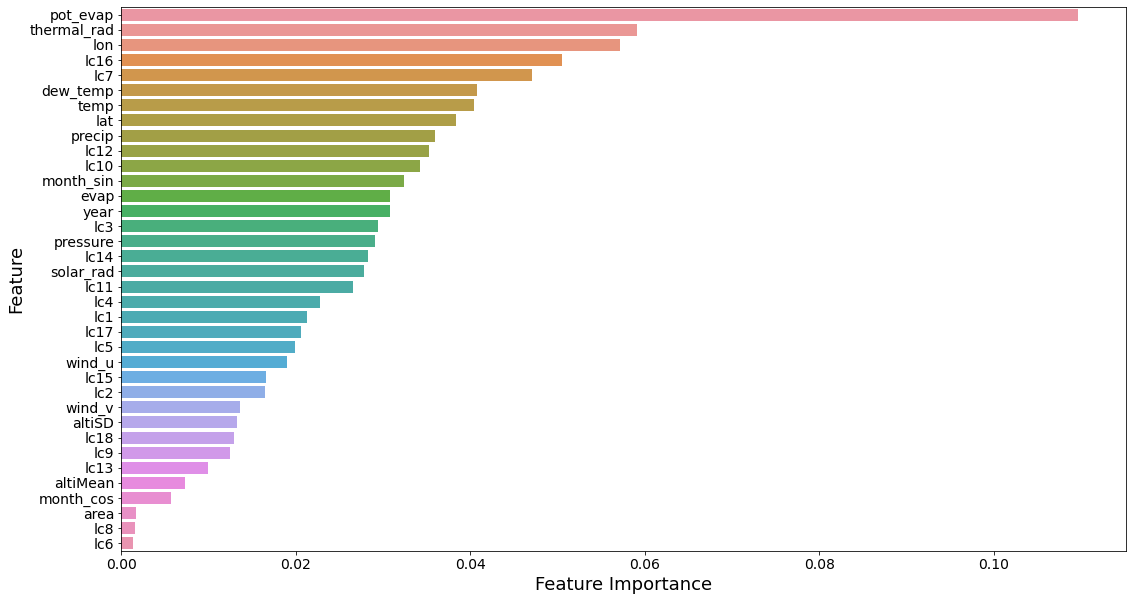

In [ ]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(data=fi_df, x='Feature Importance', y='Feature')
# plt.xscale('log')
plt.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlabel('Feature Importance', fontsize=18)
ax.set_ylabel('Feature', fontsize=18)
plt.show()

In [ ]:
per_imp = permutation_importance(
    rfr_CNT, X_test, y_test_CNT, random_state=42, n_jobs=-1
)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


In [ ]:
pi_df = pd.DataFrame(
    data={'Feature': X_train.columns, 'Permutation Importance': per_imp.importances_mean},
    columns = ['Feature', 'Permutation Importance']
    )

pi_df.sort_values('Permutation Importance', inplace=True, ascending=False)

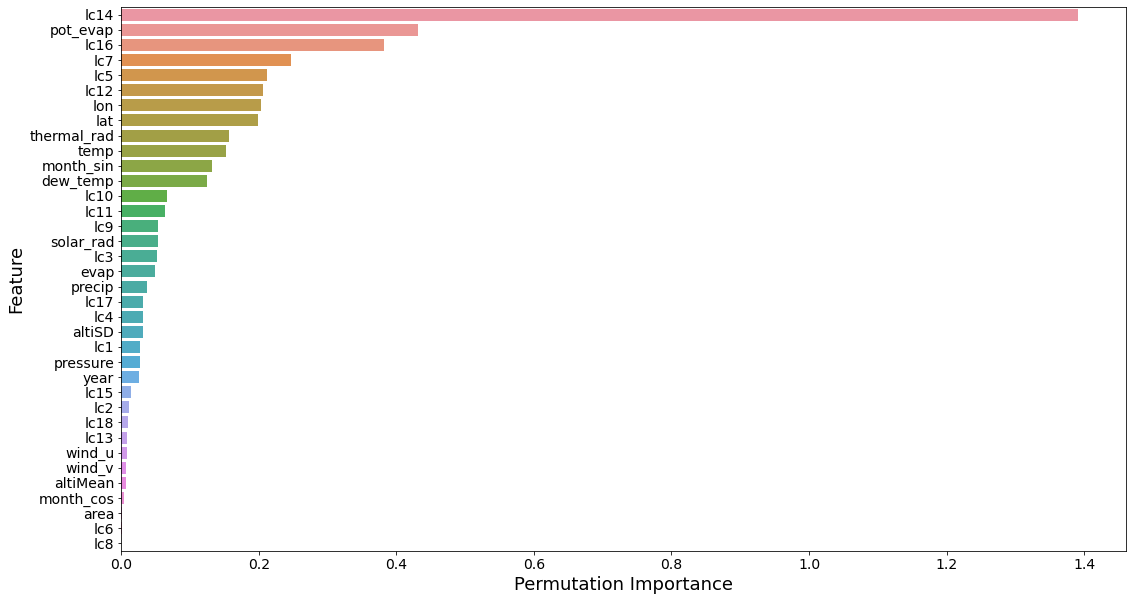

In [ ]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(data=pi_df, x='Permutation Importance', y='Feature')
# plt.xscale('log')
plt.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlabel('Permutation Importance', fontsize=18)
ax.set_ylabel('Feature', fontsize=18)
plt.show()

# Ensemble

## Getting all predictions

In [ ]:
df = transform_month(data)

#MLP
#Split Data
data_train_MLP, data_val, data_test = split_train_test(df)

#Normalize Data
X_train_MLP, y_train_CNT, y_train_BA, means, stds = preproc(data_train_MLP)
X_val_MLP, y_val_CNT, y_val_BA, _, _ = preproc(data_val, means, stds)
X_test_MLP, y_test_CNT, y_test_BA, _, _ = preproc(data_test, means, stds)

Training years: [1993, 1994, 1996, 1999, 2000, 2001, 2002, 2005, 2006, 2007, 2008, 2009, 2010, 2014, 2015]
Test years: [1998, 2004, 2011, 2013]
Validation years: [1995, 1997, 2003, 2012]


In [ ]:
mlp_CNT = keras.models.load_model('/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/Models/MLP_CNT_best')
print_mse(mlp_CNT, X_train_MLP, X_val_MLP, X_test_MLP, y_train_CNT, y_val_CNT, y_test_CNT)

Train MSE = 14.7803
Validation MSE = 17.621
Test MSE = 18.9558


In [ ]:
mlp_BA = keras.models.load_model('/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/Models/MLP_BA_best')
print_mse(mlp_BA, X_train_MLP, X_val_MLP, X_test_MLP, y_train_BA, y_val_BA, y_test_BA)

Train MSE = 12364030.2498
Validation MSE = 13804487.1522
Test MSE = 11440523.858


In [ ]:
pred_MLP_CNT_train = mlp_CNT.predict(X_train_MLP, batch_size=1024)
pred_MLP_CNT_val = mlp_CNT.predict(X_val_MLP, batch_size=1024)
pred_MLP_CNT_test = mlp_CNT.predict(X_test_MLP, batch_size=1024)

pred_MLP_BA_train = mlp_BA.predict(X_train_MLP, batch_size=1024)
pred_MLP_BA_val = mlp_BA.predict(X_val_MLP, batch_size=1024)
pred_MLP_BA_test = mlp_BA.predict(X_test_MLP, batch_size=1024)

preds_CNT_train = pd.DataFrame(data=pred_MLP_CNT_train, columns=['MLP'])
preds_CNT_val = pd.DataFrame(data=pred_MLP_CNT_val, columns=['MLP'])
preds_CNT_test = pd.DataFrame(data=pred_MLP_CNT_test, columns=['MLP'])

preds_BA_train = pd.DataFrame(data=pred_MLP_BA_train, columns=['MLP'])
preds_BA_val = pd.DataFrame(data=pred_MLP_BA_val, columns=['MLP'])
preds_BA_test = pd.DataFrame(data=pred_MLP_BA_test, columns=['MLP'])

In [ ]:
#RFR
#Split Data
data_train_RFR, data_test = split_train_test(df, val=False)

#Normalize Data
_, _, _, means, stds = preproc(data_train_RFR)
X_test_RFR, _, _, _, _ = preproc(data_test, means, stds)

Training years: [1993, 1994, 1995, 1996, 1997, 1999, 2000, 2001, 2002, 2003, 2005, 2006, 2007, 2008, 2009, 2010, 2012, 2014, 2015]
Test years: [1998, 2004, 2011, 2013]


In [ ]:
rfr_CNT = pickle.load(open('/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/Models/RFR_CNT_13', 'rb'))

In [ ]:
rfr_BA = pickle.load(open('/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/Models/RFR_BA_5', 'rb'))

In [ ]:
pred_RFR_CNT_train = rfr_CNT.predict(X_train_MLP)  #here with data split from MLP
pred_RFR_CNT_val = rfr_CNT.predict(X_val_MLP)      #perfect comparison only on test data
pred_RFR_CNT_test = rfr_CNT.predict(X_test_RFR)

pred_RFR_BA_train = rfr_BA.predict(X_train_MLP)
pred_RFR_BA_val = rfr_BA.predict(X_val_MLP)
pred_RFR_BA_test = rfr_BA.predict(X_test_RFR)

preds_CNT_train['RFR'] = pred_RFR_CNT_train
preds_CNT_val['RFR'] = pred_RFR_CNT_val
preds_CNT_test['RFR'] = pred_RFR_CNT_test

preds_BA_train['RFR'] = pred_RFR_BA_train
preds_BA_val['RFR'] = pred_RFR_BA_val
preds_BA_test['RFR'] = pred_RFR_BA_test

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

In [ ]:
path = '/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/Ensemble/'
preds_CNT_train.to_csv(path + 'CNT_train')
preds_CNT_val.to_csv(path + 'CNT_val')
preds_CNT_test.to_csv(path + 'CNT_test')
preds_BA_train.to_csv(path + 'BA_train')
preds_BA_val.to_csv(path + 'BA_val')
preds_BA_test.to_csv(path + 'BA_test')

In [ ]:
path = '/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/'

In [ ]:
cnn_CNT = keras.models.load_model(path+'Models/CNN_CNT_best')

In [ ]:
with open(path+"saved_arrays_for_CNN/"+'Training_2022-09-25-20-02-26', 'rb') as f:
    X_train_CNN = pickle.load(f)

pred_CNN_CNT_train = cnn_CNT.predict(X_train_CNN, batch_size=1024)

In [ ]:
preds_CNT_train = pd.read_csv(path + 'CNT_train', index_col=0)
preds_CNT_train['CNN'] = pred_CNN_CNT_train
preds_CNT_train['mean'] = preds_CNT_train.mean(axis=1)
preds_CNT_train['y'] = y_train_CNT.to_numpy()
preds_CNT_train.to_csv(path + 'CNT_train')

In [ ]:
with open("/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/saved_arrays_for_CNN/"+'Validation_2022-09-25-11-38-14', 'rb') as f:
    X_val_CNN = pickle.load(f)

pred_CNN_CNT_val = cnn_CNT.predict(X_val_CNN, batch_size=1024)

In [ ]:
preds_CNT_val = pd.read_csv(path + 'CNT_val', index_col=0)
preds_CNT_val['CNN'] = pred_CNN_CNT_val
preds_CNT_val['mean'] = preds_CNT_val.mean(axis=1)
preds_CNT_val['y'] = y_val_CNT.to_numpy()
preds_CNT_val.to_csv(path + 'CNT_val')

In [ ]:
with open("/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/saved_arrays_for_CNN/"+'Testing_2022-09-25-22-25-19', 'rb') as f:
    X_test_CNN = pickle.load(f)

pred_CNN_CNT_test = cnn_CNT.predict(X_test_CNN, batch_size=1024)

In [ ]:
preds_CNT_test = pd.read_csv(path + 'CNT_test', index_col=0)
preds_CNT_test['CNN'] = pred_CNN_CNT_test
preds_CNT_test['mean'] = preds_CNT_test.mean(axis=1)
preds_CNT_test['y'] = y_test_CNT.to_numpy()
preds_CNT_test.to_csv(path + 'CNT_test')

In [ ]:
cnn_BA = keras.models.load_model('/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/Models/CNN_best_BA')

In [ ]:
pred_CNN_BA_train = cnn_BA.predict(X_train_CNN, batch_size=1024)

In [ ]:
preds_BA_train = pd.read_csv(path + 'BA_train', index_col=0)
preds_BA_train['CNN'] = pred_CNN_BA_train
preds_BA_train['mean'] = preds_BA_train.mean(axis=1)
preds_BA_train['y'] = y_train_BA.to_numpy()
preds_BA_train.to_csv(path + 'BA_train')

In [ ]:
pred_CNN_BA_val = cnn_BA.predict(X_val_CNN, batch_size=1024)

In [ ]:
preds_BA_val = pd.read_csv(path + 'BA_val', index_col=0)
preds_BA_val['CNN'] = pred_CNN_BA_val
preds_BA_val['mean'] = preds_BA_val.mean(axis=1)
preds_BA_val['y'] = y_val_BA.to_numpy()
preds_BA_val.to_csv(path + 'BA_val')

In [ ]:
pred_CNN_BA_test = cnn_BA.predict(X_test_CNN, batch_size=1024)

In [ ]:
preds_BA_test = pd.read_csv(path + 'BA_test', index_col=0)
preds_BA_test['CNN'] = pred_CNN_BA_test
preds_BA_test['mean'] = preds_BA_test.mean(axis=1)
preds_BA_test['y'] = y_test_BA.to_numpy()
preds_BA_test.to_csv(path + 'BA_test')

## Evaluation

In [ ]:
path = '/content/drive/MyDrive/Master/Semester 2/Predictive Data Analytics/Wildfires/Ensemble/'

In [ ]:
preds_CNT_train = pd.read_csv(path + 'CNT_train', index_col=0)
preds_CNT_val = pd.read_csv(path + 'CNT_val', index_col=0)
preds_CNT_test = pd.read_csv(path + 'CNT_test', index_col=0)

preds_BA_train = pd.read_csv(path + 'BA_train', index_col=0)
preds_BA_val = pd.read_csv(path + 'BA_val', index_col=0)
preds_BA_test = pd.read_csv(path + 'BA_test', index_col=0)

In [ ]:
print('CNT Ensemble MSE Train: {}'.format(round(mean_squared_error(preds_CNT_train['y'],preds_CNT_train['mean']),4)))
print('CNT Ensemble MSE Val: {}'.format(round(mean_squared_error(preds_CNT_val['y'],preds_CNT_val['mean']),4)))
print('CNT Ensemble MSE Test: {}'.format(round(mean_squared_error(preds_CNT_test['y'],preds_CNT_test['mean']),4)))
print('BA Ensemble MSE Train: {}'.format(round(mean_squared_error(preds_BA_train['y'],preds_BA_train['mean']),4)))
print('BA Ensemble MSE Val: {}'.format(round(mean_squared_error(preds_BA_val['y'],preds_BA_val['mean']),4)))
print('BA Ensemble MSE Test: {}'.format(round(mean_squared_error(preds_BA_test['y'],preds_BA_test['mean']),4)))

CNT Ensemble MSE Train: 11.5448
CNT Ensemble MSE Val: 11.492
CNT Ensemble MSE Test: 16.0112
BA Ensemble MSE Train: 12330343.4566
BA Ensemble MSE Val: 13598264.8502
BA Ensemble MSE Test: 11423795.5982


# Scatterplots

## CNT

Scatterplot CNT MLP


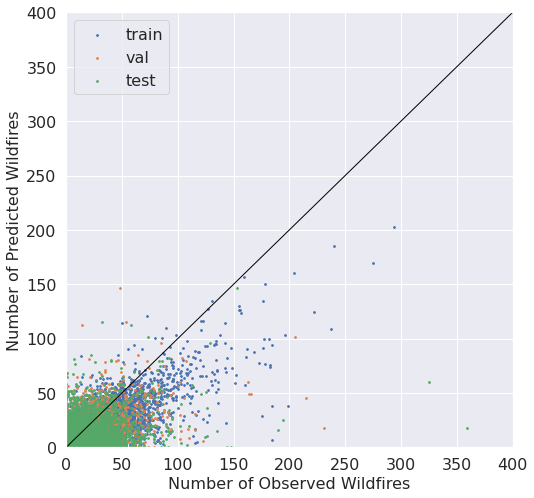


Scatterplot CNT RFR


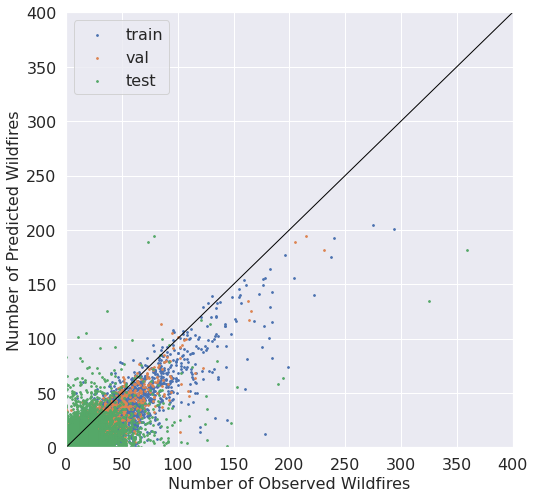


Scatterplot CNT CNN


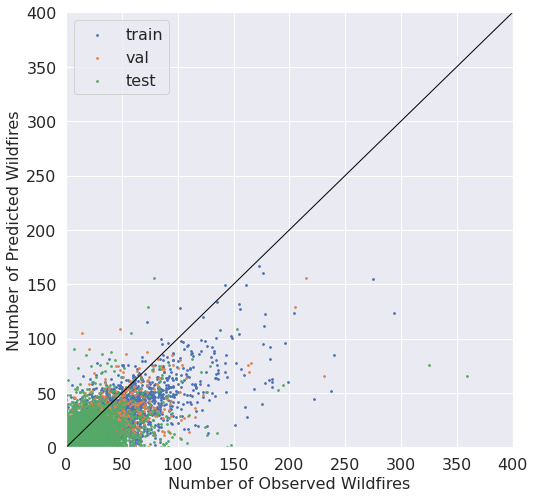


Scatterplot CNT mean


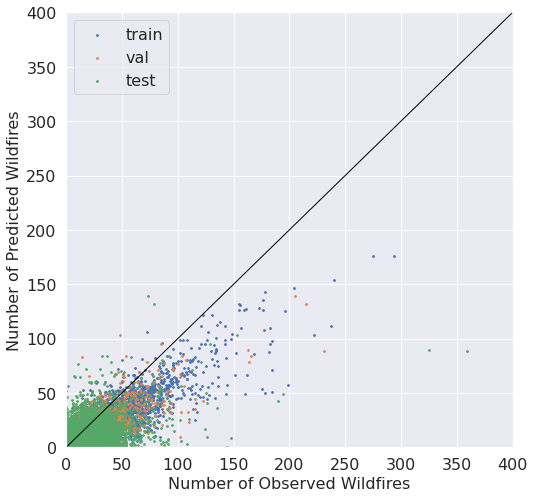

In [ ]:
sns.set()
for model in ['MLP', 'RFR', 'CNN', 'mean']:

  print('Scatterplot CNT '+model)

  fig, ax = plt.subplots(figsize=(8,8))

  ax.scatter(preds_CNT_train.y,preds_CNT_train[model], s=3, label='train')
  ax.scatter(preds_CNT_val.y,preds_CNT_val[model], s=3, label='val')
  ax.scatter(preds_CNT_test.y,preds_CNT_val[model], s=3, label='test')
  ax.set_xlabel('Number of Observed Wildfires', fontsize=16)
  ax.set_ylabel('Number of Predicted Wildfires', fontsize=16)
  ax.plot([0, 400], [0, 400], color = 'black', linewidth=1.0)
  ax.set_xlim(0,400)
  ax.set_ylim(0,400)

  plt.tick_params(axis='both', which='major', labelsize=16)

  plt.legend(fontsize=16)
  plt.show()

  print()

## BA

In [ ]:
preds_BA_train.y.quantile(.99)

1971.0859790039046

Scatterplot BA MLP


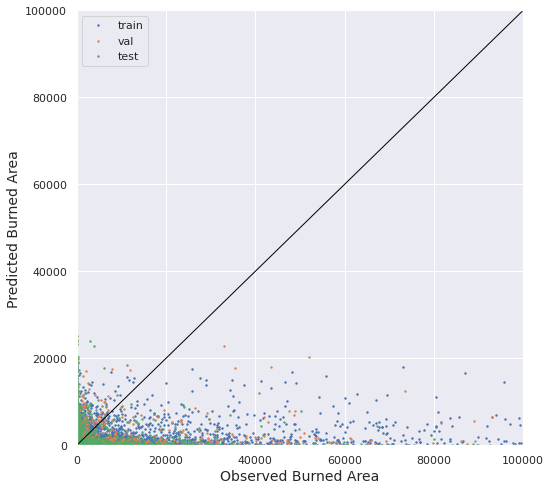


Scatterplot BA RFR


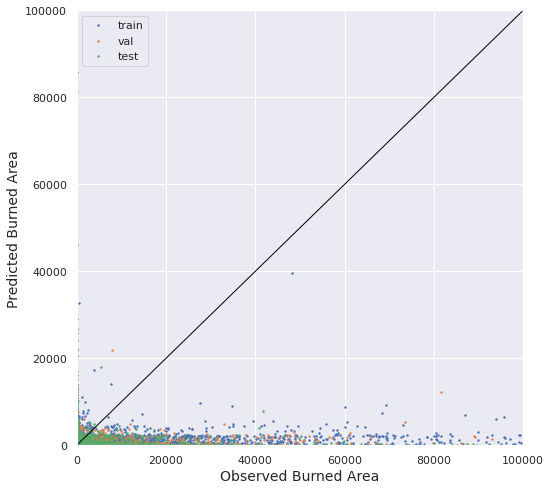


Scatterplot BA CNN


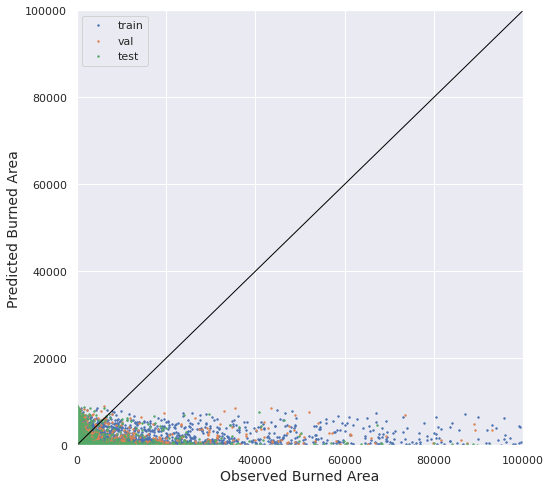


Scatterplot BA mean


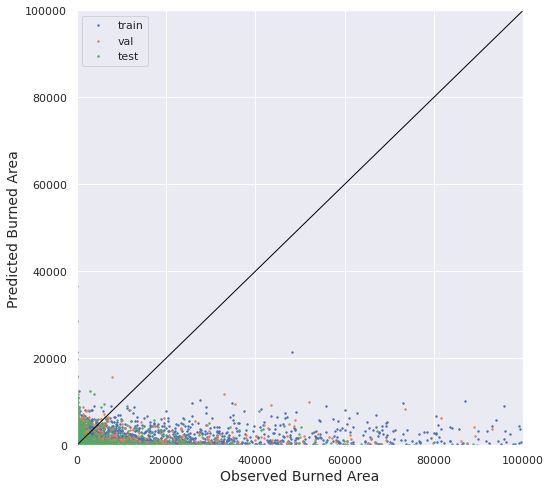

In [ ]:
sns.set()
for model in ['MLP', 'RFR', 'CNN', 'mean']:

  print('Scatterplot BA '+model)

  fig, ax = plt.subplots(figsize=(8,8))

  ax.scatter(preds_BA_train.y,preds_BA_train[model], s=2, label='train')
  ax.scatter(preds_BA_val.y,preds_BA_val[model], s=2, label='val')
  ax.scatter(preds_BA_test.y,preds_BA_val[model], s=2, label='test')
  ax.set_xlabel('Observed Burned Area', fontsize=14)
  ax.set_ylabel('Predicted Burned Area', fontsize=14)
  ax.plot([0, 100000], [0, 100000], color = 'black', linewidth=1.0)
  ax.set_xlim(0,100000)
  ax.set_ylim(0,100000)

  plt.legend()
  plt.show()

  print()